#CREACIÓN DE DICCIONARIOS Y OBTENCIÓN DE INFORMACIÓN PARA EL PROCESAMIENTO

En esta sección se dispondrá del código empleado para crear los dos instrumentos de control terminológico deseados: el tesauro de sinónimos y antónimos. Además, el procesamiento del fichero proporcionado por el porfesor servirá para obtener información adicional, como la obtención de los tamaños de ventana, a partir de la que se verá facilitado el posterior procesamiento de las respùestas de los estudiantes

En primer lugar, se importan las librerías necesarias para trabajar

In [1]:
!pip install stanza
import stanza
stanza.download("es")

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
OTHER_WORDS = ["''", '--', '``']

import requests
from bs4 import BeautifulSoup

import json
import numpy as np
import pandas as pd
import re


2021-09-18 17:53:38 INFO: Downloading default packages for language: es (Spanish)...
2021-09-18 17:53:40 INFO: File exists: /root/stanza_resources/es/default.zip.
2021-09-18 17:53:47 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Se define la clase *Viterbi*. A partir de esta clase, se decodificará la información de las tablas de probilidad de emisión y transición para encontrar la ruta de la Matriz de Viterbi que permitirá etiquetar las palabras de la oración.**

In [2]:
class Viterbi:
    '''
    Viterbi algorithm to decode HMM information. 
    '''

    def __init__(self, PTrans: pd.DataFrame(), PObs: pd.DataFrame(), DictLemmas: dict(), sentence: str):
        """
        Class constructor. 
        Parameters:
        -PTrans: The transition table of probabilities
        -PObs: The emission table of probabilities
        -DictLemmas: The dictionary of lemmas
        -sentence: The sentence that is wanted to decode 
        """
        self._q0 = 'q0'
        self._qF = 'qF'
        self.state_dictionary = {"A":"Adjective", "D":"Determiner", "N":"Noun", "V":"Verb", "P":"Pronoun", "R":"Adverb", "C":"Conjunction", "S":"Adposition", "W":"Date", "Z":"Number", "I":"Interjection", "F":"Punctuation"}
        self._sentence = sentence
        self._dictLemmas = DictLemmas
        self._PObs= PObs
        self._PTrans = PTrans

        self._relevant_states = None
        self._prob_viterbi = pd.DataFrame()
        self._previous_max_state = None
        self._tokens_list = dict()

        self.TaggedSentence = self.__OptimalDecoding() 

    """
    Public methods
    """
    
    def ViterbiProbability(self):
        """
        Returns the probability matrix of Viterbi
        """
        return self._prob_viterbi
    
    def SyntacticAnalysis(self):
        """
        Returns a list with each token of the morphosyntactically tagged sentence (token, tag)
        """
        return self.TaggedSentence

    """
    Private methods
    """

    def __truncate(self,num,n):
        """
        It truncates the value of a float number
        """
        temp = str(num)
        for x in range(len(temp)):
            if temp[x] == '.':
                try:
                    return float(temp[:x+n+1])
                except:
                    return float(temp)      
        return float(temp)

    def __RelevantStates(self):
        """
        Gets the relevant states (the name of the grammatical categories)
        """
        self._relevant_states = set()
        for category in self.state_dictionary.keys():
          self._relevant_states.add(self.state_dictionary[category])

    def __Probabilities(self):
        """
        Calculates the probability matrix of Viterbi
        """
        if len(self._prob_viterbi) != 0:
            return self._prob_viterbi.copy()

        if not self._relevant_states:
            self.__RelevantStates()

        relevant_states = self._relevant_states

        #Matrix in which the Viterbi values ​​are stored
        viterbi_matrix = {q: dict() for q in relevant_states}

        #Matrix in which it is stored the state of origin that maximizes each probability
        self._previous_max_state = {q: dict() for q in relevant_states}

        q0 = self._q0
        prob_trans = self._PTrans
        prob_obs = self._PObs
        previous_token = None

        #Penalty for classes differing from noun or adjective
        penalty = 0.000001

        #Handles word repetition cases and word counting (frequency)
        for token in [x.lower() for x in self._sentence.split()]:
          if token in self._tokens_list.keys():
            i=2
            newToken=0
            while not newToken:
                if (token+"("+str(i)+")") in self._tokens_list.keys():
                  i = i + 1
                else:
                  try:
                    isNewToken = self._dictLemmas[token]
                    self._tokens_list[token+"("+str(i)+")"] = token
                    newToken=1
                  except:
                    self._tokens_list[token+"("+str(i)+")"]= "tokenseliminados"
                    newToken=1

          else:
            try:
              isNewToken = self._dictLemmas[token]
              self._tokens_list[token]= token
            except:
              self._tokens_list[token]= "tokenseliminados"

        #Creates the Vierbi Matrix
        for token in self._tokens_list:
            for qDestiny in relevant_states:

                prob_max = 0
                if not previous_token:
                    #q0
                    prob_max = prob_trans[qDestiny][q0]
                    
                else:
                    #Rest of the states
                    for qOrigin in relevant_states:

                        prob_qOrigin = viterbi_matrix[qOrigin][previous_token] * prob_trans[qDestiny][qOrigin]

                        if prob_qOrigin > prob_max:
                            prob_max = prob_qOrigin

                #Handles the words that are not included in the dictionary of lemmas
                if self._tokens_list[token] == "tokenseliminados":
                    if qDestiny == "Noun" or qDestiny == "Adjective":
                      viterbi_matrix[qDestiny][token] = prob_max * prob_obs[self._tokens_list[token]][qDestiny]
                    else:
                      viterbi_matrix[qDestiny][token] = prob_max * prob_obs[self._tokens_list[token]][qDestiny] * penalty                    
                else:
                    viterbi_matrix[qDestiny][token] = prob_max * prob_obs[self._tokens_list[token]][qDestiny]

            previous_token = token


        self._prob_viterbi = pd.DataFrame.from_dict(viterbi_matrix, orient='index')

        return self._prob_viterbi.copy()

    def __OptimalDecoding(self):
        """
        It decodes the information previously calculated in order to get the best path in the Viterbi matrix 
        """

        prob_viterbi = self.__Probabilities()
        reverse_sentence = [x.lower() for x in self._tokens_list]
        reverse_sentence.reverse()     
        tagged_sentence = []

        #Last word of the sentence
        _word = reverse_sentence[0]
        tag = prob_viterbi[_word].idxmax()
        tagged_sentence.append({'token': _word, 'tag': tag, 'prob': prob_viterbi[_word].max()})

        #Rest of the words
        previous_word = _word
        prob_obs = self._PObs
        prob_trans = self._PTrans

        aux_state = tag
        for _word in reverse_sentence[1:]:            

            for state in self._relevant_states:                
                if  self.__truncate(prob_viterbi[previous_word][tag],6) == self.__truncate(prob_viterbi[_word][state] * prob_obs[self._tokens_list[previous_word]][tag] * prob_trans[tag][state],6):
                    aux_state = state
                    break
                  
            tag = aux_state
            tagged_sentence.append({'token': _word, 'tag': tag, 'prob': prob_viterbi[_word][tag]}) 
            previous_word = _word  


        #Getting the real order of the tokens
        tagged_sentence.reverse()


        return tagged_sentence

      
        

**Se cargan los archivos que contienen el contenido probabilístico calculado del archivo *Jupyter Notebook* donde se calcula el HMM del corpus. También, se importa el diccionario de lemas generado en dicho *notebook*.**

In [3]:
#Loading HMM probability tables
Pobs_aux= pd.read_excel(open('Total_Emission.xlsx', 'rb'))
Ptrans_aux= pd.read_excel(open('Total_Transmision.xlsx', 'rb'))
Pobs=Pobs_aux
Pobs = Pobs.set_index('Unnamed: 0')
Pobs.index.names = [None]
Ptrans=Ptrans_aux
Ptrans = Ptrans.set_index('Unnamed: 0')
Ptrans.index.names = [None]

#Loading the dictionary of lemmas
LemmaDictionary = np.load('DiccionarioLemas.npy', allow_pickle='TRUE')
LemmaDictionary = LemmaDictionary.item()

Se declara la función *non_zero_green*, que se utilizará como medio para mostrar con mayor claridad algunos valores de las tablas probabilísitcas que se generen.

In [4]:
def non_zero_green(val):
    '''
    Function to highlight probabilities other than 0 in green
    '''
    return 'background-color: Aquamarine' if val > 0 else ''

**Para ejemplificar el funcionamiento del etiquetador creado, se muestra un ejemplo de funcionamiento de la clase *Viterbi* para etiquetar la oración "El invitado vino con el vino tinto de la cosecha de 1996", en la que aparece la palabra ambigua "vino". Es importante comprobar que se consiguen diferenciar correctamente ambas acepciones de la palabra en cuestión, pues al fin y al cabo se utilizará esta clase para la desambiguación de los sentidos de las palabras**

Para ello, se instancia primero una variable de la clase *Viterbi*, introduciendo los pertinentes argumentos que necesita la clase.

In [5]:
viterbi = Viterbi(Ptrans, Pobs.T, LemmaDictionary, 'El invitado vino con el vino tinto de la cosecha de 1996')

Se obtiene el análisis morfosintáctico realizado, devolviendo el token, la etiqueta asignada y la probabilidad con la que se efectuó dicha asignación (para cada palabra)

In [6]:
viterbi.SyntacticAnalysis()

[{'prob': 0.07192326397205148, 'tag': 'Determiner', 'token': 'el'},
 {'prob': 1.547443337273614e-06, 'tag': 'Noun', 'token': 'invitado'},
 {'prob': 2.2872259174054268e-11, 'tag': 'Verb', 'token': 'vino'},
 {'prob': 3.7450276390422446e-13, 'tag': 'Adposition', 'token': 'con'},
 {'prob': 5.93807393099679e-14, 'tag': 'Determiner', 'token': 'el(2)'},
 {'prob': 6.5741514292631344e-18, 'tag': 'Noun', 'token': 'vino(2)'},
 {'prob': 2.6939675311905204e-23, 'tag': 'Adjective', 'token': 'tinto'},
 {'prob': 2.542654287528223e-24, 'tag': 'Adposition', 'token': 'de'},
 {'prob': 3.1966533933462905e-25, 'tag': 'Determiner', 'token': 'la'},
 {'prob': 7.485849821478142e-30, 'tag': 'Noun', 'token': 'cosecha'},
 {'prob': 7.586982203567827e-31, 'tag': 'Adposition', 'token': 'de(2)'},
 {'prob': 7.24345670002487e-32, 'tag': 'Noun', 'token': '1996'}]

Se muestra la matriz de probabilidad de Viterbi a partir de la que se obtuvo la ruta óptima para etiquetar las palabras

In [7]:
viterbi.ViterbiProbability()

,el,invitado,vino,con,el(2),vino(2),tinto,de,la,cosecha,de(2),1996
Noun,4.220058e-04,1.547443e-06,1.209396e-11,8.582677e-17,1.401867e-16,6.574151e-18,2.733149e-24,7.125674e-28,8.870727e-28,7.485850e-30,4.462706e-35,7.243457e-32
Pronoun,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.897162e-28,0.000000e+00,0.000000e+00,0.000000e+00
Conjunction,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.349666e-40
Adjective,1.841360e-09,0.000000e+00,0.000000e+00,0.000000e+00,2.265822e-21,0.000000e+00,2.693968e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.233613e-35
Verb,0.000000e+00,1.667307e-07,2.287226e-11,0.000000e+00,0.000000e+00,1.277377e-19,1.184983e-24,0.000000e+00,0.000000e+00,3.187481e-32,0.000000e+00,2.344697e-40
Interjection,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.701945e-43
Adverb,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.513989e-40
Punctuation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.399335e-39
Number,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.504654e-38
Date,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.544303e-39


In [8]:
viterbi.ViterbiProbability().style.applymap(non_zero_green)

,el,invitado,vino,con,el(2),vino(2),tinto,de,la,cosecha,de(2),1996
Noun,0.000422,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pronoun,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Conjunction,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Adjective,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Verb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Interjection,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Adverb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Punctuation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Number,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Date,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Se muestra el resultado con el formato normalmente usado para dicha tarea

In [9]:
for palabra in viterbi.SyntacticAnalysis():
    print('{} / {}'.format(palabra['token'], palabra['tag']))

el / Determiner
invitado / Noun
vino / Verb
con / Adposition
el(2) / Determiner
vino(2) / Noun
tinto / Adjective
de / Adposition
la / Determiner
cosecha / Noun
de(2) / Adposition
1996 / Noun


**Se define la clase *NLP_Questions*, a partir de la que se obtendrán las palabras clave a estudiar, se generá información para complementar el análisis de la respuesta del estudiante y se formarán los tesauros de antónimos y sinónimos**

In [10]:
class NLP_Questions:
    """
    Extracts the needed information to process the student's answers and creates the synonym and antonym dictionaries
    """

    def __init__(self, file_name: str, synonym_dict: dict(), antonym_dict: dict(), LemmaDictionary:dict() ):
        """
        Class constructor. 
        Parameters:
        -file_name: The path of the file where the information is stored
        -synonym_dict: The dictionary of synonyms 
        -antonym_dict: The dictionary of antonyms
        -LemmaDictionary: The dictionary of lemmas
        """        
        self.file_name = file_name
        self.synonyms = synonym_dict
        self.antonyms = antonym_dict
        self.stopwords = set(stopwords.words('spanish'))

        self.file = self.__UploadQuestions()
        self.keywords = self.__GetKeywords()
        self.tokenizedKeywords = None
        self.lemmatizedKeywords = []

        self.nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

        self.__ProcessInfo()  
        self.windowMaxSize = self.__GetWindowSizes()

    """
    Public methods
    """     

    def Keywords(self):
        """
        Returns the keyword dictionary with its lemma
        """
        return self.tokenizedKeywords

    def LemmatizedKeywords(self):
        """
        Returns a list with the lemma of each keyword
        """
        return self.lemmatizedKeywords
 
    
    def Synonyms(self):
        """
        Returns the dictionary of synonyms
        """
        return self.synonyms

    def Antonyms(self):
        """
        Returns the dictionary of antonyms
        """
        return self.antonyms
    
    def Windows(self):
        """
        Returns each window size to identify the keyword
        """      
        return self.windowMaxSize

    def SaveDictionaries(self, path=""):
        """
        Saves all the interesting information.
        Parameters:
        -path: The path where you want to save the files
        """   

        tf = open(path+"DiccionarioSinonimos.json", "w")
        json.dump(self.synonyms,tf)
        tf.close()

        tf = open(path+"DiccionarioAntonimos.json", "w")
        json.dump(self.antonyms,tf)
        tf.close()

        tf = open(path+"TokenizedKeywords.json", "w")
        json.dump(self.tokenizedKeywords,tf)
        tf.close()

        tf = open(path+"LemmatizedKeywords.json", "w")
        json.dump(self.lemmatizedKeywords,tf)
        tf.close()

        tf = open(path+"WindowMaxSize.json", "w")
        json.dump(self.windowMaxSize,tf)
        tf.close()

    
    """
    Private methods
    """

    def __UploadQuestions(self):
        """
        Gets and filters the information from the json file
        """

        with open(self.file_name + ".json", "r") as f:
            data = json.loads("[" + 
                f.read().replace("}\n{", "},\n{") + 
            "]")
        return data

    def __GetKeywords(self):
        """
        Gets all the keywords 
        """
        keywords_list = []
        for answer in self.file:
            for section in answer:
                if section == "metadata":
                    for element in answer[section]:
                        if element == "keywords":
                            for keyword in answer[section][element]:
                                if keyword in keywords_list:
                                    continue
                                else:
                                    keywords_list.append(keyword)

        return keywords_list

    def __Lemmatization(self, word):
        """
        Allows to transform a word into its lemma.
        Parameters:
        -word: The word that you want to lemmatize
        """
        try:
            lemma_aux = LemmaDictionary[word]
            #words from the dictionary of lemmas that don't need WSD
            if len(lemma_aux)==1 and word not in self.stopwords:
                for gcategory in lemma_aux:
                    lemma = lemma_aux[gcategory]

            else:
                #words from the dictionary of lemmas that need WSD
                doc = self.nlp(word)
                lemma = doc.sentences[0].words[0].lemma

        except:
                #words that are not included in the dictionary of lemmas
                doc = self.nlp(word)
                lemma = doc.sentences[0].words[0].lemma
        
        return lemma 

    def __createExpression(self,expression,word):
        """
        Creates a way to concatenate words.
        Parameters:
        -expression: the string whre you want to concatenate words
        -word: the word you want to add in the expression
        """     

        if expression == "":
            expression = word
        else:
            expression = expression + " " + word

        return expression

    def __GetWindowSizes(self):
        """
        Creates a way to concatenate words
        """ 
        list_all = []
        list_keys = []
        list_syn = []
        list_ant = []
        
        for keyword in self.lemmatizedKeywords:
            #Getting the windows of the keywords 
            length = len(keyword.split())
            if not length in list_keys:
                list_keys.append(length)

            #Getting the windows of the antonyms 
            if len(keyword.split()) == 1:
                for component in self.antonyms[keyword]["Dictionary"]:
                    for category in self.antonyms[keyword]["Dictionary"][component]:
                        for element in self.antonyms[keyword]["Dictionary"][component][category]:                                    
                            length3 = len(element.split())
                            if not length3 in list_ant:
                                list_ant.append(length3)
            
            #Getting the windows of the synonyms 
            for word in keyword.split():
                if word in self.stopwords:
                    continue
                else:
                    word_l = self.__Lemmatization(word)
                    for component in self.antonyms[word_l]["Dictionary"]:
                        for category in self.antonyms[word_l]["Dictionary"][component]:                 
  
                            if len(keyword.split()) > 1:
                                for element in self.synonyms[word_l]["Dictionary"][component][category]:                                    
                                    length2 = len(element.split())
                                    if not length2 in list_syn:
                                        list_syn.append(length2)
                            else:
                                for element in self.synonyms[keyword]["Dictionary"][component][category]:
                                    length2 = len(element.split())
                                    if not length2 in list_syn:
                                        list_syn.append(length2)
        list_keys.sort()
        list_syn.sort()
        list_ant.sort()

        list_all = [list_keys, list_syn, list_ant]
        return list_all

    def __TokenizeKeywords(self):
        """
        Processes the keywords in order to tokenize and lemmatize them
        """ 
        tokenizedKeywords = dict()
        for keyword in self.keywords:
            #Compund keywords
            if  len(keyword.split()) > 1:
                splittedKeyword = keyword.split()
                keylist = []
                keyword_buffer =""
                for word in splittedKeyword:
                    keylist.append(self.__Lemmatization(word))
                    if keyword_buffer == "":
                        keyword_buffer = self.__Lemmatization(word)
                    else:
                        keyword_buffer = keyword_buffer + " " + self.__Lemmatization(word)

                tokenizedKeywords[keyword] = keylist
                self.lemmatizedKeywords.append(keyword_buffer)
                del keylist

            else:
                #simple unit keywords
                tokenizedKeywords[keyword] = self.__Lemmatization(keyword)
                self.lemmatizedKeywords.append(self.__Lemmatization(keyword))

        return tokenizedKeywords

    def __FindSynonyms(self, word_lemma):
        """
        Accesses WordReference to get the synonyms and antonyms of each word and creates the dictionaries.
        Parameters:
        -word_lemma: The lemma of the word that you want to search in order to get its synonyms and antonyms
        """ 
        #Web scraping
        url = 'https://www.wordreference.com/sinonimos/'
        find = url + word_lemma
        resp = requests.get(find)
        bs = BeautifulSoup(resp.text, 'lxml')
        xml_list = bs.find_all(class_='trans clickable')

        #Getting the useful information 
        self.synonyms[word_lemma] = dict()
        self.antonyms[word_lemma] = dict()
        self.synonyms[word_lemma]["Dictionary"] = dict()
        self.antonyms[word_lemma]["Dictionary"] = dict()
        word_synonym = []
        word_antonym = []
        for tree in xml_list:
          node= tree.find_all('li')
          names= tree.find_all('h3')
          for name in names:
              word = name.next_element
          for content in node:
            compare1 = content.find_all('span')
            compare2 =[content.next_element]
            if compare2 == compare1:
              for info in compare1:
                ant= info.next_element.split(',  ')
                for element2 in ant:
                    element2 = element2.replace("Antónimos: ","")
                    if len(element2.split()) == 1:
                        word_antonym.append(self.__Lemmatization(element2))
                    else:
                        expression=""
                        for subword in element2.split():
                            expression = self.__createExpression(expression, self.__Lemmatization(subword))
                        word_antonym.append(expression)

            else:
              sin =content.next_element.split(',  ')
              for element in sin:
                if len(element.split()) == 1:
                    word_synonym.append(self.__Lemmatization(element))
                else:
                    expression=""
                    for subword in element.split():
                        expression = self.__createExpression(expression, self.__Lemmatization(subword))

                    word_synonym.append(expression)

          #Indexing the levels of the dictionary and adding the information
          doc = self.nlp(word)
          self.synonyms[word_lemma]["Dictionary"][word] = dict()
          self.antonyms[word_lemma]["Dictionary"][word] = dict()  
          self.synonyms[word_lemma]["Dictionary"][word][doc.sentences[0].words[0].upos] = dict()
          self.antonyms[word_lemma]["Dictionary"][word][doc.sentences[0].words[0].upos] = dict()  
          self.synonyms[word_lemma]["Dictionary"][word][doc.sentences[0].words[0].upos] = word_synonym.copy()
          self.antonyms[word_lemma]["Dictionary"][word][doc.sentences[0].words[0].upos] = word_antonym.copy()

          word_synonym.clear()
          word_antonym.clear()
          self.synonyms[word_lemma]["Compound"] = 0
          self.antonyms[word_lemma]["Compound"] = 0

    def __ProcessInfo(self):
        """
        Main programme of the class
        """
        self.tokenizedKeywords = self.__TokenizeKeywords()
        for keyword in self.tokenizedKeywords:

            if  len(keyword.split()) == 1:
                if self.tokenizedKeywords[keyword] in self.synonyms.keys():
                    continue
                else:
                    #Analyze simple unit keywords
                    self.__FindSynonyms(self.tokenizedKeywords[keyword])
                    doc = self.nlp(self.__Lemmatization(keyword))
                    self.synonyms[self.__Lemmatization(keyword)]["GCategory"] = doc.sentences[0].words[0].upos                      

            else:
                #Getting the units of a compound word to analyze them too
                for word in self.tokenizedKeywords[keyword]:
                    if word in self.stopwords:
                        continue
                    else:
                        #Indicate that the word is not a keyword itself
                        self.__FindSynonyms(word) 
                        self.synonyms[word]["Compound"] = 1
                        self.antonyms[word]["Compound"] = 1

                        doc = self.nlp(self.__Lemmatization(word))
                        self.synonyms[self.__Lemmatization(word)]["GCategory"] = doc.sentences[0].words[0].upos  
                           


**Se crea la instancia *file_info* de la clase *NLP_Questions* que leerá la información del fichero contenido en la ruta file_name. Los diccionarios de sinónimos y antónimos están vacíos para ajustar concretamente la información al examen incluído en *file_name*.**

In [11]:
emptySynonymDict= dict()
emptyAntonymDict= dict()
file_name = "metodos-de-captura-conNota-Anon"

file_info = NLP_Questions(file_name,emptySynonymDict,emptyAntonymDict, LemmaDictionary)

2021-09-18 17:54:50 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-09-18 17:54:50 INFO: Use device: cpu
2021-09-18 17:54:50 INFO: Loading: tokenize
2021-09-18 17:54:50 INFO: Loading: mwt
2021-09-18 17:54:50 INFO: Loading: pos
2021-09-18 17:54:51 INFO: Loading: lemma
2021-09-18 17:54:52 INFO: Done loading processors!
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor

**A continuación, se muestra la información procesada y extraída del fichero, así como los tesauros construídos:**

Lista de los *keywords* lematizados extraídos

In [12]:
file_info.LemmatizedKeywords()

['respaldo',
 'balanceo de carga',
 'disponibilidad',
 'replicación',
 'arbitrar',
 'votación',
 'sustitución',
 'exportar',
 'actualizar']

Diccionaro cuyas claves son los *keywords* originales del listado del profesor y su contenido son los mismos lematizados. Este diccionario es de carácter informativo, no se utilizará para procesar las respuestas 

In [13]:
file_info.Keywords()

{'actualizada': 'actualizar',
 'arbitro': 'arbitrar',
 'balanceo de carga': ['balanceo', 'de', 'carga'],
 'disponibilidad': 'disponibilidad',
 'exporta': 'exportar',
 'replicación': 'replicación',
 'respaldo': 'respaldo',
 'sustitución': 'sustitución',
 'votación': 'votación'}

Tesauro de sinónimos con los distintos índices adicionales incorporados

In [14]:
file_info.Synonyms()

{'actualizar': {'Compound': 0,
  'Dictionary': {'actualizar': {'VERB': ['modernizar',
     'renovar',
     'rejuvenecer',
     'reemplazar',
     'restablecer',
     'reformar',
     'restaurar',
     'modificar',
     'poner al día']}},
  'GCategory': 'VERB'},
 'arbitrar': {'Compound': 0,
  'Dictionary': {'arbitrar': {'VERB': ['interceder',
     'mediar',
     'intermediar',
     'intervenir',
     'interponer',
     'resolver',
     'fallar',
     'sentenciar',
     'dictaminar',
     'decidir',
     'establecer',
     'juzgar',
     'actuar',
     'agenciar',
     'servir',
     'ingeniar',
     'valerse',
     'lograr',
     'conseguir']}},
  'GCategory': 'VERB'},
 'balanceo': {'Compound': 1,
  'Dictionary': {'balancear': {'VERB': ['columpiar',
     'mecer',
     'bambolear',
     'contonear',
     'menear',
     'mover',
     'ondular',
     'oscilar',
     'titubear',
     'dudar',
     'vacilar']},
   'balanceo': {'NOUN': ['fluctuación',
     'vaivén',
     'bamboleo',
     'bal

Tesauro de antónimos con los distintos índices adicionales incorporados

In [15]:
file_info.Antonyms()

{'actualizar': {'Compound': 0,
  'Dictionary': {'actualizar': {'VERB': ['envejecer']}}},
 'arbitrar': {'Compound': 0,
  'Dictionary': {'arbitrar': {'VERB': ['inhibir', 'abstener']}}},
 'balanceo': {'Compound': 1,
  'Dictionary': {'balancear': {'VERB': []}, 'balanceo': {'NOUN': []}}},
 'carga': {'Compound': 1,
  'Dictionary': {'carga': {'NOUN': []},
   'cargar': {'VERB': ['vaciar',
     'descargar',
     'aligerar',
     'aliviar',
     'agradar',
     'entretener',
     'arreglar',
     'despejar',
     'abrir']}}},
 'disponibilidad': {'Compound': 0,
  'Dictionary': {'disponibilidad': {'NOUN': []}}},
 'exportar': {'Compound': 0,
  'Dictionary': {'exportar': {'VERB': ['importar', 'comprar']}}},
 'replicación': {'Dictionary': {}},
 'respaldo': {'Compound': 0,
  'Dictionary': {'respaldar': {'VERB': ['desamparar', 'desaprobar']},
   'respaldo': {'NOUN': ['desamparo', 'desprotección']}}},
 'sustitución': {'Compound': 0, 'Dictionary': {'sustitución': {'NOUN': []}}},
 'votación': {'Compound':

Tamaños de ventana obtenidos para cada *set* (palabras clave-sinónimos-antónimos)

In [16]:
file_info.Windows()

[[1, 3], [1, 3], [1]]

Se almacena la información generada

In [17]:
file_info.SaveDictionaries()

# PROCESAMIENTO DE LAS RESPUESTAS DE LOS ALUMNOS

En esta sección, se procesarán las respuestas de los estudiantes para localizar las palabras clave que incluyeron. En base al número de éstas, se calculará una nota determinada y se generará el *feedback* correspondiente. 

**En primer lugar, se crea la clase *NLP_Answers* que contendrá las funciones para procesar las respuestas de cada estudiante a partir de la información extraída de la clase *NLP_Questions*.**

In [18]:
class NLP_Answers:

    """
    Processes the sentences of each student to find keywords and calculates the mark of each one
    """

    def __init__(self, file_name: str, synonym_dict: dict(), antonym_dict: dict(), keywords_dict: dict(), LemmaDictionary:dict(), PTrans: pd.DataFrame(), PObs: pd.DataFrame(), windowMaxSize = [[1], [1], [1]]):
        """
        Class constructor.
        Parameters:
        -file_name: The path of the file that contains the information
        -synonym_dict: The dictionary of synonyms
        -antonym_dict: The dictionary of antonyms
        -keywords_dict: The list of lemmatized keywords
        -LemmaDictionary: The dictionary of lemmas
        -PTrans: The probability table of transition
        -PObs: The probability table of emission
        -windowMaxSize: The sizes of window of each set (keyword-synonym-antonym)
        """         
        self.windowMaxSize = windowMaxSize
        self.file_name = file_name
        self.synonyms = synonym_dict
        self.antonyms = antonym_dict
        self.keywords = keywords_dict
        self._LemmaDictionary = LemmaDictionary
        self._PObs= PObs
        self._PTrans = PTrans

        self.stopwords = set(stopwords.words('spanish')).union(set(string.punctuation), set(OTHER_WORDS))
        self.nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

        self.feedback = dict()
        self.califications = dict()
        self.feedback_nofilter = dict()
        self.califications_nofilter = dict()

        self.lemmatizedSentence = None

        self.file = self.__UploadAnswers()  
        self.__ProcessInfo() 
    
    
    """
    Public methods
    """

    def showFeedback(self):
        """
        Returns the filtered feedback of each student's answer
        """
        return self.feedback
    def showMarks(self):
        """
        Returns the filtered found keywords and the given mark of each student's answer
        """
        return self.califications

    def showFeedbackDistribution(self):
        """
        Returns the feedback of each student's answer
        """
        return self.feedback_nofilter

    def showKeywordsDistribution(self):
        """
        Returns the found keywords and the given mark of each student's answer
        """
        return self.califications_nofilter


    """
    Private methods
    """

    def __SentenceLemmatization(self, sentence, complete_analysis = 0):
        """
        It calculates the lemma and the grammatical category of each word of the sentence
        Parameters:
        -sentence: The sentence you want to lemmatize
        -complete_analysis: 0 for processing only keywords with Viterbi, 1 for complete analysis
        """   
        sentence_split = sentence.split()
        useViterbi = 0
        lemmatized_sentence = []        


        for token in sentence_split:
            token = token.lower()
            try:
                lemma_aux = LemmaDictionary[token]

            except:
                lemma_aux = {'Ninguno': 'ninguno'}

            #Checking if Viterbi analysis is needed
            if complete_analysis:
                if len(lemma_aux)>1 and self.__Lemmatization(token) not in self.stopwords:
                    useViterbi = 1
                    break
            else:
                break_loop = 0
                if len(lemma_aux)>1 and self.__Lemmatization(token) not in self.stopwords:
                    for option in lemma_aux.keys():
                        if lemma_aux[option] in self.keywords:
                            break_loop = 1
                            useViterbi = 1
                            break
                    if break_loop:
                        break
        #Applying the Viterbi algorithm        
        if useViterbi:
            viterbi = Viterbi(self._PTrans, self._PObs.T, self._LemmaDictionary, sentence)
            tagged_sentence = viterbi.SyntacticAnalysis() 
            lemmatized_sentence = list()
            for _word in tagged_sentence:
                _word['token'] = _word['token'].lower()
                try:
                    _word_aux = re.sub("\(|\)|0|1|2|3|4|5|6|7|8|9|0","", _word['token'])
                    lemma_aux = LemmaDictionary[_word_aux]
                    lemmatized_sentence.append([lemma_aux[_word['tag']], _word['tag']])
                except:
                    lemmatized_sentence.append([_word['token'], _word['tag']])

        else:
            #Applying Stanza
            for token in sentence_split:
                token = token.lower()
                doc = self.nlp(token)
                lemmatized_sentence.append([self.__Lemmatization(token), doc.sentences[0].words[0].upos])


        return lemmatized_sentence


    def __Lemmatization(self, word):
        """
        Calculates the lemma of a word
        Parameters:
        -word: The word you want to lemmatize
        """ 
        try:
            lemma_aux = self._LemmaDictionary[word]
            
            #Using the dictionary of lemmas if the word is a simple unit
            if len(lemma_aux)==1 and word not in self.stopwords:
                for gcategory in lemma_aux:
                    lemma = lemma_aux[gcategory]

            else:
                #using stanza
                doc = self.nlp(word)
                lemma = doc.sentences[0].words[0].lemma

        except:
            #using stanza
            doc = self.nlp(word)
            lemma = doc.sentences[0].words[0].lemma

        return lemma 

    def __createExpression(self,expression,word):
        """
        Creates a way to concatenate words
        Parameters:
        -expression: the string whre you want to concatenate words
        -word: the word you want to add in the expression
        """         
        if expression == "":
            expression = word
        else:
            expression = expression + " " + word

        return expression      

    
    def __UploadAnswers(self):
        """
        Gets the information of each student from the json file
        """ 
        with open(self.file_name + ".json", "r") as f:
            data = json.loads("[" + 
                f.read().replace("}\n{", "},\n{") + 
            "]")
        return data

    def __GetStudentsAnswers(self):
        """
        Gets the answer and ID of each student 
        """ 
        StudentsAnswers_list = []
        StudentsID_list = []
        for answer in self.file:
            for section in answer:
                if section == "respuesta":
                    StudentsAnswers_list.append(answer[section])
                if section == "hashed_id":
                    StudentsID_list.append(answer[section])

        return StudentsAnswers_list, StudentsID_list
     


    def __PrepareSentence(self, answer):
        """
        Divides the sentence into shorter phrases for easier processing
        Parameters:
        -answer: The sentence you want to divide 
        """  
        new_sentences = []
        #division criteria
        sentences = re.split(r'((?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s)', answer)
        for sentence in sentences:
            if len(sentence.split()) > 10:
                division_sentences = sentence.split(",")
                for division in division_sentences:
                    #making sure all symbols are off the word
                    new_sentences.append(re.sub("\n|\.|\,|\:|\"|\;","",division))
            else:
                #making sure all symbols are off the word
                new_sentences.append(re.sub("\n|\.|\,|\:|\"|\;","",sentence))

        return new_sentences


    def __SentenceTransformation(self, sentence):
        """
        Makes a sentence from the lemmas that were calculated in __SentenceLemmatization
        Parameters:
        -sentence: The string that is going to be lemmatized
        """         
        sentence = sentence.lower()
        new_sentence = ""
        for token in self.lemmatizedSentence:
            new_sentence = self.__createExpression(new_sentence,token[0])
        
        return new_sentence

    def __isInSentence(self,sentence, search_word):
        """
        Searches if a word appears in a sentence or group of words
        Parameters:
        -sentence: A given sentence
        -search_word: The word you want to search for in that sentence
        """ 
        for word in sentence:
            word=word.lower()
            if word == search_word:
                return 1
        return 0

    def __CalculateMark(self, student):
        """
        Calculates and assigns the mark of each student given the keywords that were found
        Parameters:
        -student: The ID of the student you are going to evaluate
        """ 

        self.feedback_nofilter[student] = self.feedback[student].copy()
        self.califications_nofilter[student] = self.califications[student].copy()
        
        #Filtering the repeated feedback of the student
        filtered_list = [x for x in self.feedback[student] if x != []]
        new_list = []
        for row in filtered_list:
            for feedback_element in row:
                new_list.append(feedback_element)

        self.feedback[student] = list(set(new_list))
        
        #Filtering the repeated number of keywords
        filtered_list = [x for x in self.califications[student] if x != []]
        new_list = []
        for row in filtered_list:
            for keyword_element in row:
                new_list.append(keyword_element)
        
        self.califications[student] = [] 
        self.califications[student].append(list(set(new_list)))

        #Evaluating the student
        Mark = 1 * len(self.califications[student][0])/len(self.keywords)
        self.califications[student].append("Nota: " + str(round(Mark, 2)))      
          
 
    def __isNegated(self, sentence, word, window):
        """
        Searches if an antonym appears negated in the sentence
        Parameters:
        -sentence: A given sentence
        -word: The antonym that you are analyzing
        -window: The window size to look 
        """ 

        negated_words = ["no", "nunca", "jamás", "nada", "ni", "siquiera", "ningún", "tampoco", "ninguno", "nadie", "ninguna"]

        isNegated = 0
        words=""
        for i in range(len(sentence)-window+1):
          for j in range(window):
            words = self.__createExpression(words, sentence[i+j])
          
          for adverb in negated_words:
              if adverb in words and word in words:
                  isNegated = True   
                  break
              else:
                words=""
        return isNegated

    def __isWordInWindow(self,phrase, word, window):
        """
        Scrolls a variable size filter to search for matches in the sentence
        Parameters:
        -phrase: A given sentence
        -word: The word you want to check if it is in the sentence
        -window: The window size to look 
        """ 

        if len(word.split()) != window:
            return 0
        else:
            #Preparing the word that you are going to search
            new_word=""
            for token in word.split():
              new_word = self.__createExpression(new_word, token)
              
            isInside = 0
            words=""
            #Checking if the word is in the sentence (in a given window)
            for i in range(len(phrase)-window+1):
              for j in range(window):
                words = self.__createExpression(words, phrase[i+j])
              #If there is a match, stop searching
              if words.lower() == new_word.lower():
                isInside = True   
                break
              else:
                words=""
            return isInside


    def __calculateGrammarCategory(self, sentence, keyword):
        """
        Gets the grammatical category of a word
        Parameters:
        -sentence: A given sentence
        -keyword: The keyword you want to know its grammatical category
        """ 
        grammatical_category = []
        for token in self.lemmatizedSentence:
            if token[0] == keyword:
                grammatical_category.append(token[1])      
            
        return grammatical_category

    def __Evaluate(self, sentence, student):
        """
        Creates searching loops in order to find keywords in the sentence
        Parameters:
        -sentence: A given sentence
        -student: The ID of the student whose answer you are analyzing
        """
        words_guessed=[]
        feedback_list = []
        sentence = self.__SentenceTransformation(sentence)
        sentence_split = sentence.split()
        wlist1 = self.windowMaxSize[0]
        wlist2 = self.windowMaxSize[1]
        wlist3 = self.windowMaxSize[2]

        #Search for keywords
        for windowsize in wlist1:
            for keyword in self.keywords:
                #Checking the existence of a keyword
                if self.__isWordInWindow(sentence_split, keyword, windowsize):
                    sintax_good= 1
                    for component in keyword.split():
                        grammatical_category = self.__calculateGrammarCategory(sentence, component)                  

                        for g_category in grammatical_category:
                            if component in self.stopwords:
                                continue
                            else:
                                #checking if the keyword has the correct grammatical category
                                if g_category == self.synonyms[component]["GCategory"] or len(self.synonyms[component]["Dictionary"]) == 0:
                                    if len(keyword.split()) == 1:
                                        feedback_list.append("La palabra clave " + keyword + " aparece correctamente utilizada en el texto")
                                        words_guessed.append(keyword)
                                        
                                else:
                                    sintax_good = 0
                                    feedback_list.append("La palabra clave " + keyword + " aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado")
                                    words_guessed.append(keyword)
                      
                    #checking if the keyword has the correct grammatical category for a commpound keyword
                    if sintax_good and len(keyword.split()) > 1:
                        feedback_list.append("La expresión clave " + keyword + " aparece correctamente empleada en el texto")
                        words_guessed.append(keyword)
                    elif not sintax_good and len(keyword.split()) > 1:
                        feedback_list.append("La expresión clave " + keyword + " aparece, pero su significado podría no ser el adecuado")
                        words_guessed.append(keyword)

        #Search for synonyms
        for windowsize in wlist2:
            for keyword in self.keywords:
                #Checking the existence of a synonym
                if len(keyword.split())==1 and len(self.synonyms[keyword]["Dictionary"]) > 0 and not self.synonyms[keyword]["Compound"]:
                    for component in self.synonyms[keyword]["Dictionary"]:
                        if component != keyword and self.__isInSentence(sentence_split, component):
                            feedback_list.append("La palabra " + component + " aparece en el texto y es una forma de expresar la palabra clave " + keyword + ", pero su significado puede no ser el adecuado")
                            words_guessed.append(keyword)

                        for category in self.synonyms[keyword]["Dictionary"][component]:
                            for element in self.synonyms[keyword]["Dictionary"][component][category]:
                                if self.__isWordInWindow(sentence_split, element, windowsize):
                                    if len(element.split())>1:
                                        feedback_list.append("En el texto aparece la expresión " + element + ", que es sinónima del lema de la palabra clave " + keyword)
                                        words_guessed.append(keyword)
                                    
                                    else: 
                                        #checking the grammatical category of the synonym                                      
                                        grammatical_category = self.__calculateGrammarCategory(sentence, element)

                                        for g_category in grammatical_category:
                                            if g_category == self.synonyms[keyword]["GCategory"] or len(self.synonyms[keyword]["Dictionary"]) ==  0:
                                                feedback_list.append("En el texto aparece la palabra " + element + ", que es sinónima del lema de la palabra clave " + keyword)
                                                words_guessed.append(keyword)
                                            else:
                                                feedback_list.append("El sinonimo " + element + " de la palabra clave " + keyword + " aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado")
                                                words_guessed.append(keyword)
                #analyzing compound keywords                                                             
                elif len(keyword.split()) > 1:
                    no_word = 0
                    expression = ""
                    for word in keyword.split():
                        #Analyze each one of the units of a compound word
                        if self.__isInSentence(sentence_split, word):
                            expression = self.__createExpression(expression, word)
                        else:
                            no_word = 1
                            for component in self.synonyms[word]["Dictionary"]:
                                for category in self.synonyms[word]["Dictionary"][component]:
                                    for sin in self.synonyms[word]["Dictionary"][component][category]:
                                        if self.__isInSentence(sentence_split, sin):
                                            no_word = 0
                                            expression = self.__createExpression(expression, sin)
                                        else:
                                            continue
                        if no_word:
                            break
                    #if the compound keyword match
                    if not no_word:
                        if self.__isWordInWindow(sentence_split, expression,windowsize):
                            if expression == keyword:
                                continue
                            else:
                                feedback_list.append("En el texto aparece la expresión " + expression + ", que es sinónima de la sentencia clave " + keyword)
                                words_guessed.append(keyword)
        #Search for antonyms
        for windowsize in wlist3:
            for keyword in self.antonyms.keys():
                if len(self.antonyms[keyword]["Dictionary"]) == 0:
                    continue
                else:
                    for component in self.antonyms[keyword]["Dictionary"]:
                        for category in self.antonyms[keyword]["Dictionary"][component]:
                            for element in self.antonyms[keyword]["Dictionary"][component][category]: 
                                #Analyzing if the antonym exists in the sentence                            
                                if self.__isWordInWindow(sentence_split, element, windowsize):
                                    #Analyzing if the antonym has a negated word near
                                    if self.__isNegated(sentence_split, word, 5):
                                        feedback_list.append("En el texto aparece la palabra " + element + " negada, que es antónima de " + keyword)
                                        words_guessed.append(keyword)
                                    else:
                                        feedback_list.append("Aparece la palabra " + element + ", que es antónima de " + keyword + ", pero no se ha encontrado ninguna forma de negación, por lo que podría no compartir el significado buscado")
                                        words_guessed.append(keyword)                                                     
        
        #Collecting and saving the information of the given student
        self.feedback[student].append(list(set(feedback_list)))
        self.califications[student].append(list(set(words_guessed)))

    def __ProcessInfo(self):
        """
        Main programme of the class
        """
        answers, IDs = self.__GetStudentsAnswers()
        #Getting the answer and ID of the student
        for student_answer, ID in zip(answers, IDs):
            self.feedback[ID] = []
            self.califications[ID] = []
            sentences = self.__PrepareSentence(student_answer)
            #Analyze all the sentences of the student's answer
            for sentence in sentences:
                self.lemmatizedSentence = self.__SentenceLemmatization(sentence)
                self.__Evaluate(sentence, ID)
            #Calculate the mark               
            self.__CalculateMark(ID)  
       



**Se crea la instancia *answers* de la clase *NLP_Answers*. Se le proporciona la información previamente obtenida y la ruta al fichero. El procesamiento de las respuestas incluídas en el fichero *file_name* se procesarán automáticamente**

In [19]:
answers = NLP_Answers(file_name,file_info.Synonyms(), file_info.Antonyms(), file_info.LemmatizedKeywords(), LemmaDictionary, Ptrans, Pobs, file_info.Windows())

2021-09-18 17:54:59 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-09-18 17:54:59 INFO: Use device: cpu
2021-09-18 17:54:59 INFO: Loading: tokenize
2021-09-18 17:54:59 INFO: Loading: mwt
2021-09-18 17:54:59 INFO: Loading: pos
2021-09-18 17:54:59 INFO: Loading: lemma
2021-09-18 17:54:59 INFO: Done loading processors!


**A continuación, se muestra el resultado del procesamiento para cada estudiante:**

Se muestra el feedback que cada estudiante recibió

In [20]:
answers.showFeedback()

{'00f519bb9a67b464ecab71f3b57fe021': ['La palabra clave disponibilidad aparece correctamente utilizada en el texto',
  'En el texto aparece la palabra servir, que es sinónima del lema de la palabra clave arbitrar'],
 '02a50793837b6c2e3c8105f4c1314b9a': [],
 '035c2f163c323880b81f7ba756ef9989': ['El sinonimo posible de la palabra clave disponibilidad aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
  'La palabra clave actualizar aparece correctamente utilizada en el texto',
  'La palabra clave respaldo aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
  'La palabra clave replicación aparece correctamente utilizada en el texto',
  'En el texto aparece la palabra actuar, que es sinónima del lema de la palabra clave arbitrar',
  'El sinonimo respaldo de la palabra clave respaldo aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
  

Se muestran los *keywords* que cada estudiante incluyó en su respuesta y la nota calculada por este método en función del número de éstos

In [21]:
answers.showMarks()

{'00f519bb9a67b464ecab71f3b57fe021': [['disponibilidad', 'arbitrar'],
  'Nota: 0.22'],
 '02a50793837b6c2e3c8105f4c1314b9a': [[], 'Nota: 0.0'],
 '035c2f163c323880b81f7ba756ef9989': [['actualizar',
   'arbitrar',
   'replicación',
   'respaldo',
   'disponibilidad'],
  'Nota: 0.56'],
 '03d07d645997a8aa7eb3d739a951dc77': [['disponibilidad'], 'Nota: 0.11'],
 '053db5667b1dcc66a2f7b9c7cd192b3b': [['exportar',
   'actualizar',
   'arbitrar',
   'respaldo',
   'disponibilidad'],
  'Nota: 0.56'],
 '054b955cfb5d435f27ff18b109b136e1': [['votación',
   'sustitución',
   'actualizar',
   'balanceo de carga',
   'arbitrar',
   'respaldo',
   'disponibilidad'],
  'Nota: 0.78'],
 '056bdb4edcb6f1fa3cb6e7ede99d87e6': [['votación', 'disponibilidad'],
  'Nota: 0.22'],
 '07dcf54484cec166857559a76ff4afe8': [['disponibilidad',
   'arbitrar',
   'votación',
   'replicación'],
  'Nota: 0.44'],
 '091cbf16b7d7bad3e5df864638c62903': [['disponibilidad', 'arbitrar'],
  'Nota: 0.22'],
 '0bfec56634f5a93b60bd6d91cc142

Se muestra el feedback que cada estudiante recibió por cada frase de su contestación

In [22]:
answers.showFeedbackDistribution()

{'00f519bb9a67b464ecab71f3b57fe021': [['La palabra clave disponibilidad aparece correctamente utilizada en el texto'],
  [],
  [],
  [],
  [],
  [],
  [],
  ['La palabra clave disponibilidad aparece correctamente utilizada en el texto'],
  ['La palabra clave disponibilidad aparece correctamente utilizada en el texto'],
  ['En el texto aparece la palabra servir, que es sinónima del lema de la palabra clave arbitrar'],
  [],
  ['La palabra clave disponibilidad aparece correctamente utilizada en el texto']],
 '02a50793837b6c2e3c8105f4c1314b9a': [[]],
 '035c2f163c323880b81f7ba756ef9989': [[],
  [],
  ['La palabra clave replicación aparece correctamente utilizada en el texto',
   'La palabra clave disponibilidad aparece correctamente utilizada en el texto'],
  [],
  [],
  [],
  ['El sinonimo posible de la palabra clave disponibilidad aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado'],
  [],
  ['La palabra clave disponibilidad aparece correcta

Se muestran los *keywords* que cada estudiante incluyó en su respuesta por cada frase de su respuesta

In [23]:
answers.showKeywordsDistribution()

{'00f519bb9a67b464ecab71f3b57fe021': [['disponibilidad'],
  [],
  [],
  [],
  [],
  [],
  [],
  ['disponibilidad'],
  ['disponibilidad'],
  ['arbitrar'],
  [],
  ['disponibilidad']],
 '02a50793837b6c2e3c8105f4c1314b9a': [[]],
 '035c2f163c323880b81f7ba756ef9989': [[],
  [],
  ['disponibilidad', 'replicación'],
  [],
  [],
  [],
  ['disponibilidad'],
  [],
  ['disponibilidad', 'arbitrar'],
  [],
  ['arbitrar'],
  [],
  ['actualizar'],
  ['respaldo', 'disponibilidad'],
  ['respaldo', 'disponibilidad']],
 '03d07d645997a8aa7eb3d739a951dc77': [[], ['disponibilidad']],
 '053db5667b1dcc66a2f7b9c7cd192b3b': [['respaldo'],
  [],
  ['arbitrar'],
  [],
  ['disponibilidad'],
  ['respaldo'],
  [],
  ['exportar', 'actualizar'],
  [],
  ['respaldo']],
 '054b955cfb5d435f27ff18b109b136e1': [[],
  [],
  ['respaldo'],
  [],
  ['disponibilidad'],
  [],
  [],
  [],
  [],
  ['votación', 'arbitrar'],
  [],
  ['respaldo'],
  [],
  ['disponibilidad', 'actualizar'],
  ['sustitución'],
  [],
  ['disponibilidad'],

Se guarda la información calculada para su posterior análisis

In [24]:
tf = open("Feedback.json", "w")
json.dump(answers.showFeedback(),tf)
tf.close()

tf = open("Marks.json", "w")
json.dump(answers.showMarks(),tf)
tf.close()

tf = open("FeedbackDistribution.json", "w")
json.dump(answers.showFeedbackDistribution(),tf)
tf.close()

tf = open("MarksDistribution.json", "w")
json.dump(answers.showKeywordsDistribution(),tf)
tf.close()

# RESULTADOS

En esta sección se analizarán los resultados obtenidos para poder extraer conclusiones de los mismos y de su relación con la nota real que obtuvieron los estudiantes

En primer lugar, se importan las librerías necesarias (si se quisiera únicamente ejecutar este capítulo del notebook)

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import json
import re

Se importan también los archivos del procesamiento de la respuesta de cada alumno:

In [26]:
tf = open("Marks.json", "r")
file_marks = json.load(tf)
tf.close()

tf = open("Feedback.json", "r")
file_feedback = json.load(tf)
tf.close()

tf = open("TokenizedKeywords.json", "r")
file_keywords = json.load(tf)
tf.close()

tf = open("MarksDistribution.json", "r")
file_marksDistrib = json.load(tf)
tf.close()

tf = open("FeedbackDistribution.json", "r")
file_feedbackDistrib = json.load(tf)
tf.close()

Se muestra un ejemplo particularizado a un estudiante en concreto

In [27]:
file_feedback["eb9121746ee55b359a9eefa8f6378365"]

['La palabra clave actualizar aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
 'El sinonimo haber de la palabra clave disponibilidad aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
 'En el texto aparece la palabra enviar, que es sinónima del lema de la palabra clave exportar',
 'La palabra clave disponibilidad aparece correctamente utilizada en el texto',
 'En el texto aparece la palabra conseguir, que es sinónima del lema de la palabra clave arbitrar']

In [28]:
file_feedbackDistrib["eb9121746ee55b359a9eefa8f6378365"]

[['La palabra clave disponibilidad aparece correctamente utilizada en el texto'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['El sinonimo haber de la palabra clave disponibilidad aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado'],
 [],
 [],
 [],
 [],
 ['En el texto aparece la palabra enviar, que es sinónima del lema de la palabra clave exportar'],
 [],
 [],
 [],
 [],
 [],
 ['En el texto aparece la palabra conseguir, que es sinónima del lema de la palabra clave arbitrar'],
 [],
 [],
 [],
 ['El sinonimo haber de la palabra clave disponibilidad aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado'],
 ['La palabra clave actualizar aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado'],
 [],
 [],
 ['La palabra clave actualizar aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado']]

In [29]:
file_marks["eb9121746ee55b359a9eefa8f6378365"]

[['exportar', 'disponibilidad', 'arbitrar', 'actualizar'], 'Nota: 0.44']

In [30]:
file_marksDistrib["eb9121746ee55b359a9eefa8f6378365"]

[['disponibilidad'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['disponibilidad'],
 [],
 [],
 [],
 [],
 ['exportar'],
 [],
 [],
 [],
 [],
 [],
 ['arbitrar'],
 [],
 [],
 [],
 ['disponibilidad'],
 ['actualizar'],
 [],
 [],
 ['actualizar']]

Se carga y se obtiene el listado de keywords lematizados

In [31]:
lemmatizedKeywords = []

for f in file_keywords.keys():
    if len(f.split())>1:
        lemmatizedKeywords.append(f)
    else:
        lemmatizedKeywords.append(file_keywords[f])

**Se forman dos listas para comparar los valores de las notas calculadas (*marks*) con respecto a las reales (*real_marks*)**

In [32]:
marks = []

for student in file_marks:
    marks.append([student, float(re.sub("Nota: ", "", file_marks[student][1]))])

In [33]:
name = "metodos-de-captura-conNota-Anon"
with open(name + ".json", "r") as f:
    file2 = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")


real_marks = []
for answer in file2:
    real_marks.append([answer["hashed_id"],float(answer["nota"])])
  

Se guardan dichas listas y de adaptan al formato necesario para su tratamiento posterior

In [34]:
df = pd.DataFrame(marks)
df.to_csv('CSV_marks.csv')

df = pd.DataFrame(real_marks)
df.to_csv('CSV_real_marks.csv')

In [35]:
real_marks = np.array(real_marks)
marks = np.array(marks)

In [36]:
real_marks[:, 1] = real_marks[:, 1].astype('float')

**COMPARATIVA DE LA DIFERENCIA DE LAS NOTAS CALCULADAS**

In [37]:
real_marks_category = list(set(real_marks[:,1]))
real_marks_category.sort()

len_list = []
for student in file_marks:
    real2 = real_marks[:,0].tolist()
    idx = real2.index(student)
    len_list.append([len(file_marks[student][0]), real_marks[idx,1].astype(np.float32)])
    if len(file_marks[student][0]) > 0 and  real_marks[idx,1].astype(np.float32) <= 0.1 :
        print("La ID del estudiante que obtuvo un cero incluyendo 4 keywords fue: ", student)

La ID del estudiante que obtuvo un cero incluyendo 4 keywords fue:  cc74af2802f44d4dd32ff43c7035e086


Se identifica la respuesta del estudiante que, a pesar de acertar 4 palabras clave, obtuvo una calificación de cero, y se analiza su contestación

In [38]:
file_feedback["cc74af2802f44d4dd32ff43c7035e086"]

['La palabra clave actualizar aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
 'La palabra clave arbitrar aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
 'La palabra clave respaldo aparece en el texto, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
 'En el texto aparece la palabra actuar, que es sinónima del lema de la palabra clave arbitrar',
 'El sinonimo respaldo de la palabra clave respaldo aparece, pero no con la categoría gramatical buscada, por lo que su sentido podría ser inadecuado',
 'La palabra clave disponibilidad aparece correctamente utilizada en el texto']

In [39]:
file_marks["cc74af2802f44d4dd32ff43c7035e086"]

[['respaldo', 'disponibilidad', 'arbitrar', 'actualizar'], 'Nota: 0.44']

Se representa gráficamente la diferencia entre ambas notas

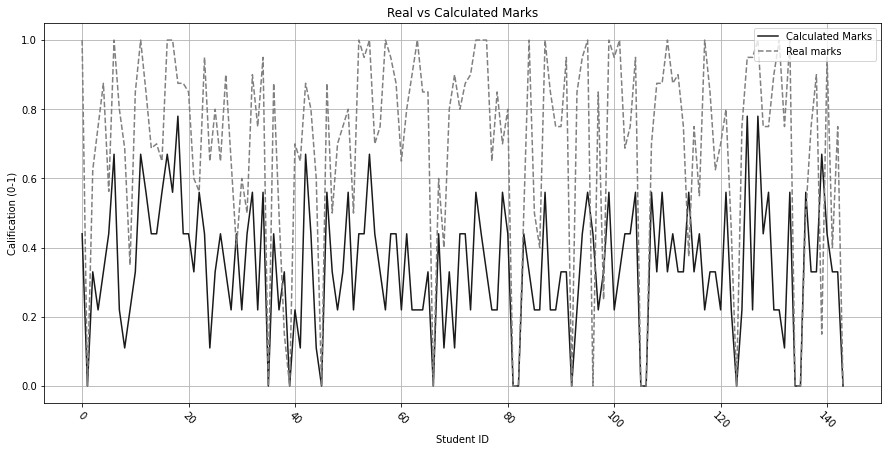

In [40]:
x = []
for i in range(len(marks[:, 0])):
    x.append(i)

plt.figure(figsize=(15,7))
plt.plot(x, marks[:,1].astype(np.float32), label = "Calculated Marks", color = (0.1,0.1,0.1))
plt.plot(x, real_marks[:,1].astype(np.float32), '--', label = "Real marks", color = (0.5,0.5,0.5))
plt.xlabel("Student ID")
plt.ylabel("Calification (0-1)")
plt.legend(loc=1)
plt.title("Real vs Calculated Marks")
plt.xticks(rotation=-45)
plt.grid()
plt.savefig("Img_All_RealvsCalculatedMarks_1.png")

In [41]:
cmpMarks_list=[]

for j in real_marks_category:
    if round(float(j),3) >= 0:
        for i in range(len(len_list)):  
            if round(float(real_marks[i][1]),3) == round(float(j),3):
                cmpMarks_list.append([marks[i][1],real_marks[i][1]])


cmpMarks_list = np.array(cmpMarks_list)

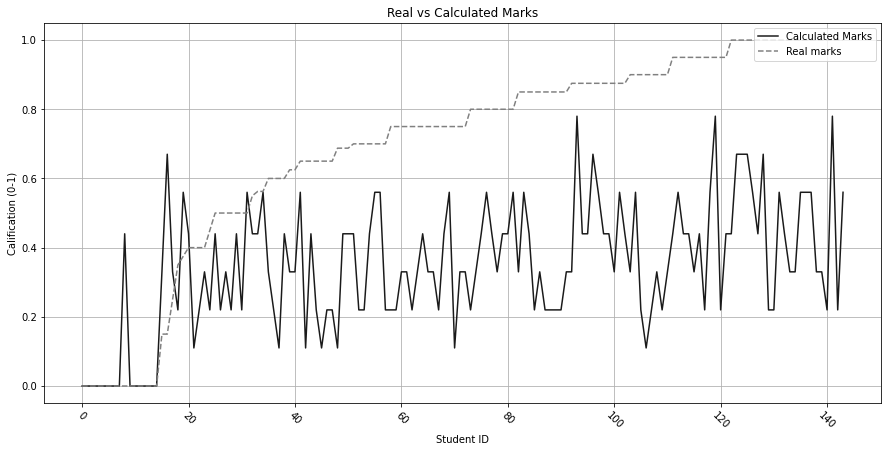

In [42]:
x = []
for i in range(len(marks[:, 0])):
    x.append(i)

plt.figure(figsize=(15,7))
plt.plot(x, cmpMarks_list[:, 0].astype(np.float32), label = "Calculated Marks", color = (0.1,0.1,0.1))
plt.plot(x, cmpMarks_list[:, 1].astype(np.float32), '--', label = "Real marks", color = (0.5,0.5,0.5))
plt.xlabel("Student ID")
plt.ylabel("Calification (0-1)")
plt.legend(loc=1)
plt.title("Real vs Calculated Marks")
plt.xticks(rotation=-45)
plt.grid()
plt.savefig("Img_All_RealvsCalculatedMarks_2.png")

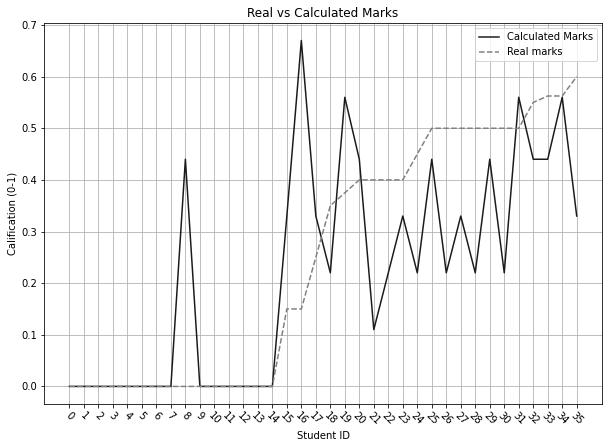

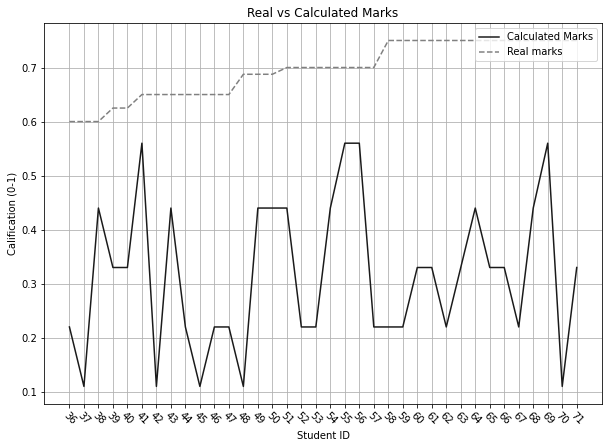

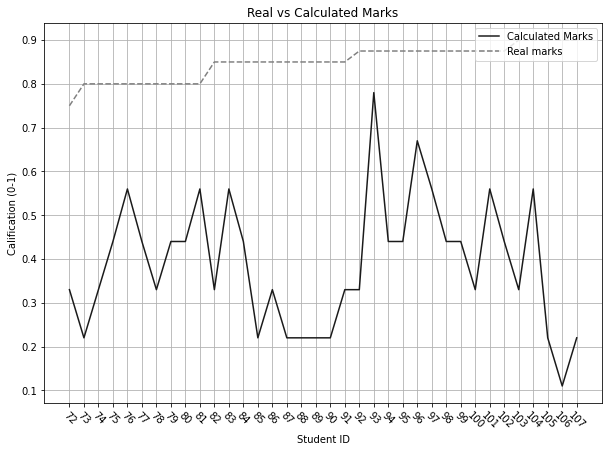

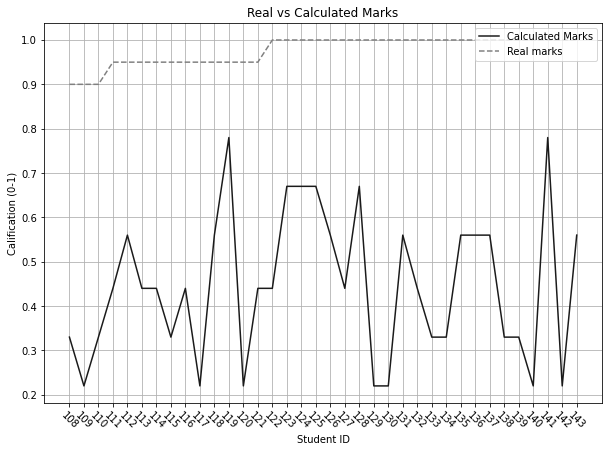

In [43]:
group_dimensions = [36,72, 108, 144]
group_idx1 = 0
group_idx2 = group_dimensions[0]

for group in range(4):
    x = []
    for i in range(len(marks[group_idx1:group_idx2, 0])):
        x.append(i + group_idx1)

    plt.figure(figsize=(10,7))
    plt.plot(x, cmpMarks_list[group_idx1:group_idx2, 0].astype(np.float32), label = "Calculated Marks", color = (0.1,0.1,0.1))
    plt.plot(x, cmpMarks_list[group_idx1:group_idx2, 1].astype(np.float32), '--', label = "Real marks", color = (0.5,0.5,0.5))
    plt.xlabel("Student ID")
    plt.ylabel("Calification (0-1)")
    plt.legend(loc=1)
    plt.title("Real vs Calculated Marks")
    plt.xticks(x,rotation=-45)
    plt.grid()
    plt.savefig("Img_RealvsCalculatedMarks_" + str(group+1) + ".png")

    try:
        group_idx1 = group_dimensions[group]
        group_idx2 = group_dimensions[group + 1]
    except:
        continue

    

**ERRORES ABSOLUTOS ENTRE AMBAS NOTAS**

Se calcula y se representa el error absoluto existente entre las notas

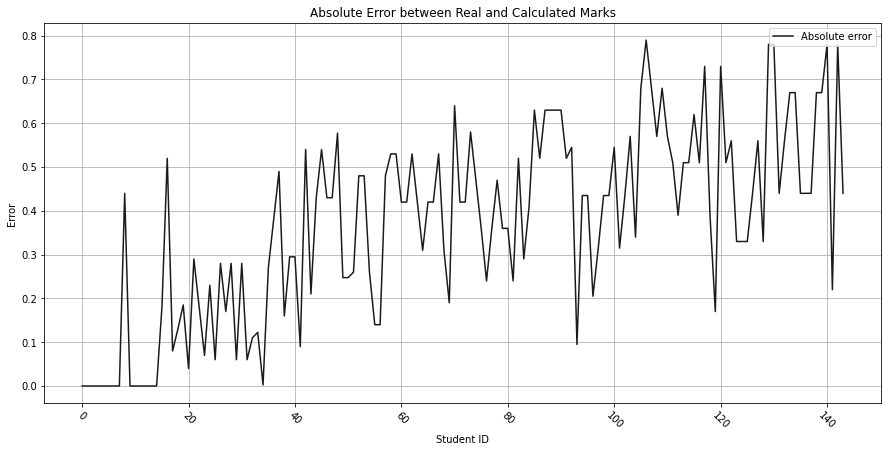

In [44]:
x = []
vabs = []
for i in range(len(marks[:, 0])):
    x.append(i)
    num = float(cmpMarks_list[i,1]) - float(cmpMarks_list[i,0])
    vabs.append(abs(num))

plt.figure(figsize=(15,7))
plt.plot(x, vabs, label = "Absolute error", color = (0.1,0.1,0.1))

plt.xlabel("Student ID")
plt.ylabel("Error")
plt.legend(loc=1)
plt.title("Absolute Error between Real and Calculated Marks")
plt.grid()
plt.xticks(rotation=-45)
plt.savefig("Img_All_AbsoluteError_1.png")

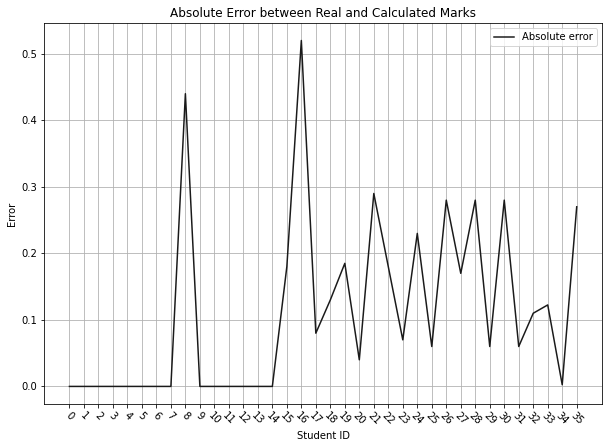

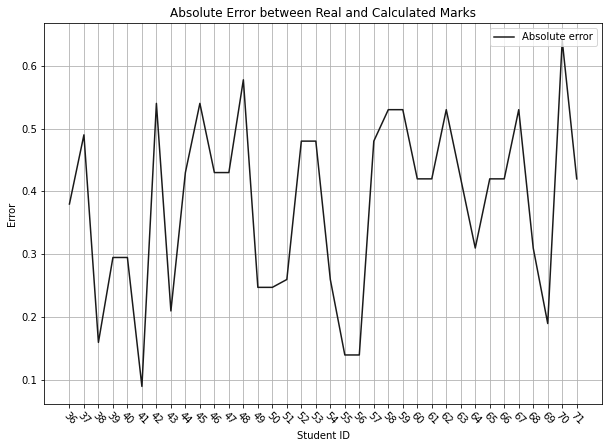

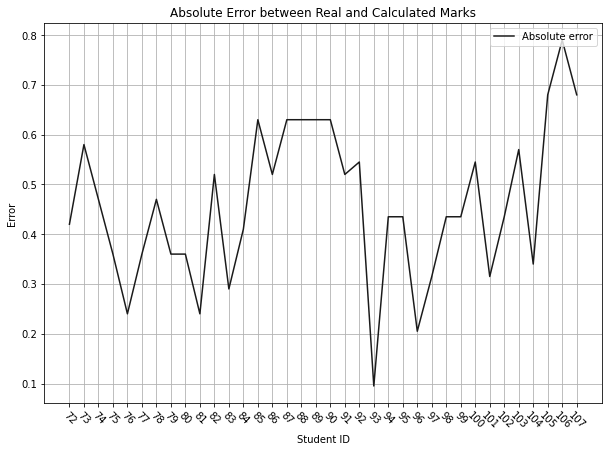

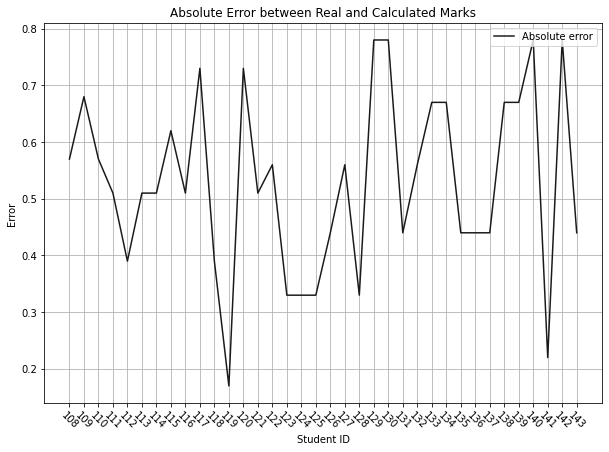

In [45]:
group_dimensions = [36,72, 108, 144]
group_idx1 = 0
group_idx2 = group_dimensions[0]
for group in range(4):
    x = []
    vabs = []
    for i in range(len(marks[group_idx1:group_idx2, 0])):
        x.append(i + group_idx1)
        num = float(cmpMarks_list[i + group_idx1,1]) - float(cmpMarks_list[i + group_idx1,0])
        vabs.append(abs(num))

    plt.figure(figsize=(10,7))
    plt.plot(x, vabs, label = "Absolute error", color = (0.1,0.1,0.1))
    
    plt.xlabel("Student ID")
    plt.ylabel("Error")
    plt.legend(loc=1)
    plt.title("Absolute Error between Real and Calculated Marks")
    plt.grid()
    plt.xticks(x,rotation=-45)
    plt.savefig("Img_AbsoluteError_" + str(group+1) + ".png")

    try:
        group_idx1 = group_dimensions[group]
        group_idx2 = group_dimensions[group + 1]
    except:
        continue

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


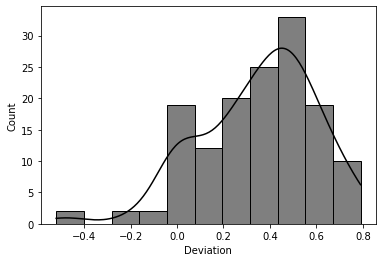

In [46]:
vabs = []
for i in range(len(marks[:, 0])):
    num = float(real_marks[i,1]) - float(marks[i,1])
    vabs.append(num)

ax=sns.histplot(
        data    = real_marks[:, 1],
        x       = vabs,
        stat    = "count",
        kde     = True,
        color = "black"
    )
ax.set(xlabel='Deviation', ylabel='Count')

figure = ax.get_figure()    
figure.savefig('Img_Desviacion.png')

**TRATAMIENTO DE DATOS**

Se genera un dataframe para observar el número de ocurrencias por nota

In [47]:
df = pd.DataFrame()

for keyword in lemmatizedKeywords:
    df[keyword] = None


for nota in real_marks_category:
    df.loc[nota] = [0] * len(lemmatizedKeywords)

In [48]:
for nota in real_marks_category:
    for keyword in lemmatizedKeywords:
        for student in file_marks:
            for guess in file_marks[student][0]:                
                real2 = real_marks[:,0].tolist()
                idx = real2.index(student)
                if guess == keyword and round(float(nota),2) == round(float(real_marks[idx,1]),2) :
                    df.loc[nota][keyword] += 1


Se muestra y guarda el dataframe calculado

In [49]:
df

,respaldo,balanceo de carga,disponibilidad,replicación,arbitrar,votación,sustitución,exportar,actualizar
0.0,1,0,1,0,1,0,0,0,1
0.15,1,0,2,0,1,1,1,2,1
0.25,0,0,1,1,0,0,0,1,0
0.35,1,0,1,0,0,0,0,0,0
0.375,1,0,1,1,1,0,0,1,0
0.4,2,0,3,2,2,0,0,0,1
0.45,0,0,1,1,0,0,0,0,0
0.5,3,0,6,1,5,3,1,1,2
0.55,1,0,1,1,1,0,0,0,0
0.5625,1,0,2,2,1,1,1,0,1


In [50]:
df.to_csv('CSV_FrecuenciaNotas.csv')

A continuación, se genera un dataframe para observar la relación entre los keywords

In [51]:
df = pd.DataFrame()

for keyword in lemmatizedKeywords:
    df[keyword] = None

df["nota"] = None

for student in file_marks:
    df.loc[student] = [0] * (len(lemmatizedKeywords)+1)


In [52]:
for keyword in lemmatizedKeywords:
    for student in file_marks:
        real2 = real_marks[:,0].tolist()
        idx = real2.index(student)  
        df.loc[student]["nota"] = round(float(real_marks[idx,1]),2)
        for guess in file_marks[student][0]:              
            if guess == keyword :
                df.loc[student][keyword] += 1

Se muestra y guarda el dataframe calculado

In [53]:
df

,respaldo,balanceo de carga,disponibilidad,replicación,arbitrar,votación,sustitución,exportar,actualizar,nota
1056c39c8300ac26304ad7463f5ea8ce,0,0,1,1,1,1,0,0,0,1
dde1a2be8c3e40859868f7c68c4a74ef,0,0,0,0,0,0,0,0,0,0
56b47fc533b4f14267f5887cb9103b05,1,0,1,0,0,0,1,0,0,0.62
2e7405e83d52a3f78f50c8ca6f16d961,1,0,1,0,0,0,0,0,0,0.75
b5b1b7329e33e1ba1459273adae97e78,0,0,1,0,1,0,0,0,1,0.88
...,...,...,...,...,...,...,...,...,...,...
88ab1d4208b2a7f96662ead8c313efa8,1,0,1,0,1,1,1,1,0,0.15
d0b36b1b57e447cb11157d9c3f3a6ff2,1,0,1,1,0,0,0,0,1,0.95
da4af2113dc6448568b6b35d1ca8c9d4,0,0,1,0,1,0,0,0,1,0.4
6a617ebdfa1f4c1ce62c268c9038b0c8,0,1,1,0,0,0,0,0,1,0.75


In [54]:
df.to_csv('CSV_VectoresNotas.csv')

Se analizan las columnas generadas y se convierten al tipo de datos real que corresponden, pues la variable nota no es categórica sino numérica

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1056c39c8300ac26304ad7463f5ea8ce to 39e7c6fcf3761c9b8d35b98c8c382305
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   respaldo           144 non-null    object
 1   balanceo de carga  144 non-null    object
 2   disponibilidad     144 non-null    object
 3   replicación        144 non-null    object
 4   arbitrar           144 non-null    object
 5   votación           144 non-null    object
 6   sustitución        144 non-null    object
 7   exportar           144 non-null    object
 8   actualizar         144 non-null    object
 9   nota               144 non-null    object
dtypes: object(10)
memory usage: 17.4+ KB


In [56]:
df[['nota']] = df[['nota']].astype(float)

Se obtienen los datos estadísticos y descriptivos de cada variable (numérica o categórica)

In [57]:
df.describe(include="all")

,respaldo,balanceo de carga,disponibilidad,replicación,arbitrar,votación,sustitución,exportar,actualizar,nota
count,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.000000
unique,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
top,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
freq,86.0,136.0,120.0,99.0,84.0,114.0,125.0,112.0,92.0,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.694028
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300448
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900000


In [58]:
df.describe(include="all").to_csv('DfDescribe.csv')

En la tabla, los valores de frecuencia que aparecen son los correspondientes a la moda de cada categoría. En muchos de los *keywords*, la moda es el 0 (la no aparición del *keyword*). Lo que interesa es la frecuencia de aparición (la de 1), como se observa para la variable respaldo

In [59]:
pd.value_counts(df["respaldo"])

0    86
1    58
Name: respaldo, dtype: int64

In [60]:
100 * df['respaldo'].value_counts() / len(df['respaldo'])

0    59.722222
1    40.277778
Name: respaldo, dtype: float64

**RELACION INDEPENDIENTE ENTRE LOS KEYOWRDS Y LA NOTA**

Se obtienen las distintas gráficas comparativas para determinar la influencia de cada keyword en cada caso

In [61]:
for keyword in lemmatizedKeywords:
    ax = pd.crosstab(index=df['nota'],
                columns=df[keyword], margins=True)
    ax.to_csv("CSV_"+keyword + "_frequency.csv")
    ax = pd.crosstab(index=df['nota'], columns=df[keyword]
           ).apply(lambda r: r/r.sum() *100,
                                axis=1)
    ax.to_csv("CSV_"+keyword + "_frequencyPercentage.csv")

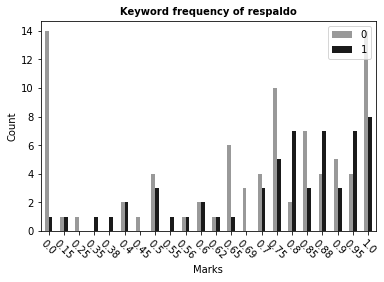

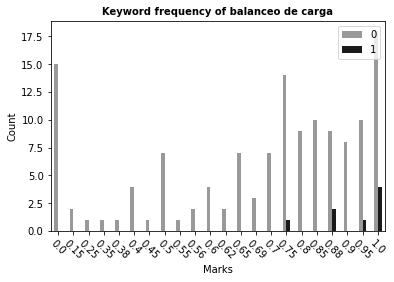

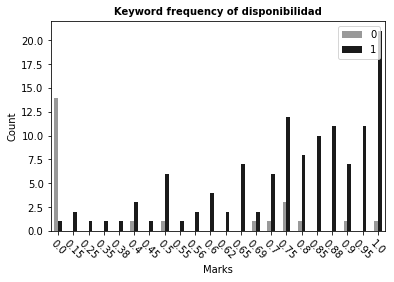

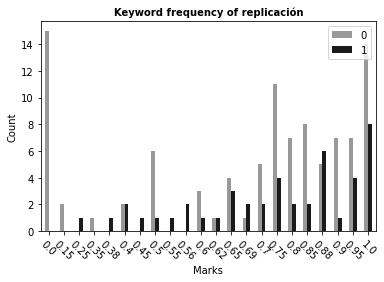

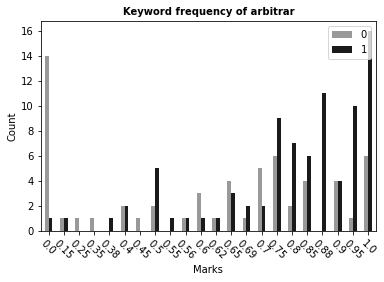

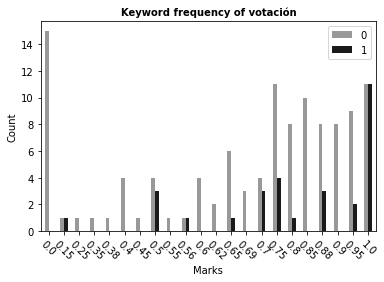

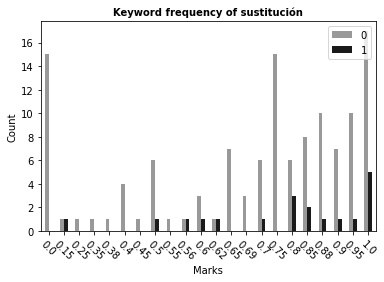

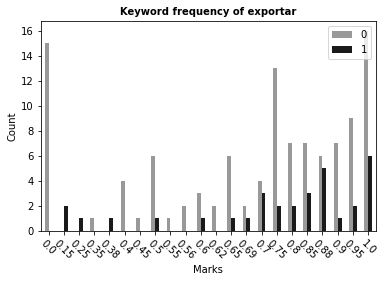

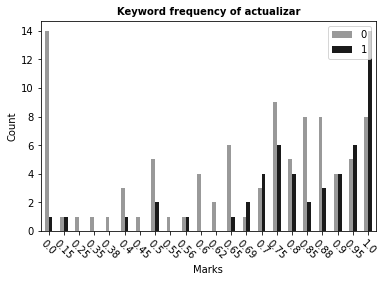

In [62]:
for keyword in lemmatizedKeywords:
    plot = pd.crosstab(index=df['nota'],
                columns=df[keyword]).plot(kind='bar', color = [(0.6,0.6,0.6),(0.1,0.1,0.1)])
    plot.set_title("Keyword frequency of " + keyword, fontsize = 10, fontweight = "bold")
    plt.xlabel("Marks")
    plt.ylabel("Count")
    plt.legend(loc=1)
    plt.xticks(rotation=-45)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig("Img_Keyword "+ keyword + " Frequency" + ".png")


**RELACION ENTRE LOS DISTINTOS KEYOWRDS Y LA NOTA**

Se obtienen las distintas gráficas comparativas para determinar la influencia existentre entre un keyword con respecto a los demás y con respecto a la nota

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

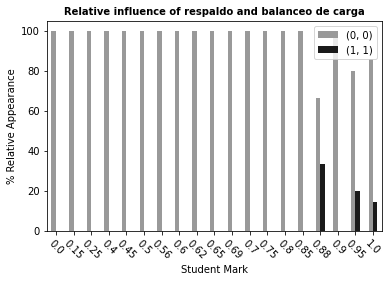

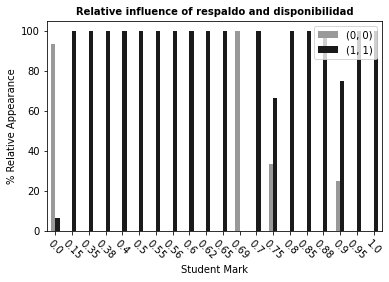

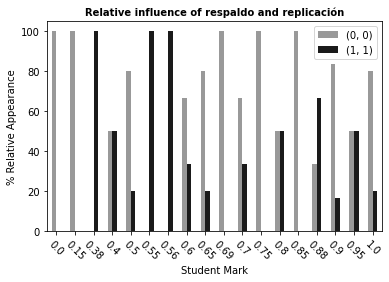

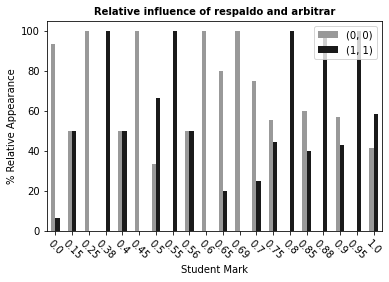

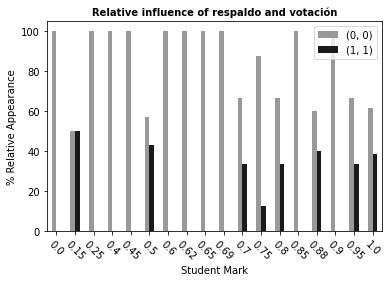

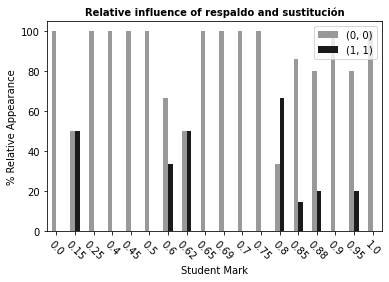

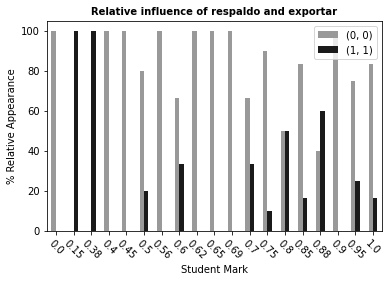

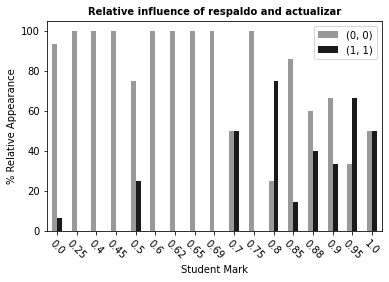

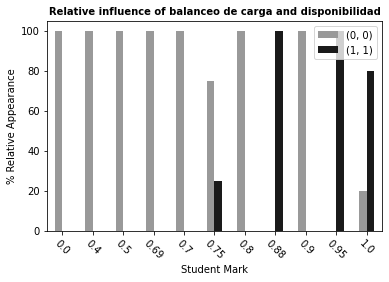

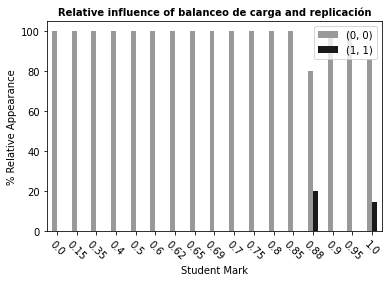

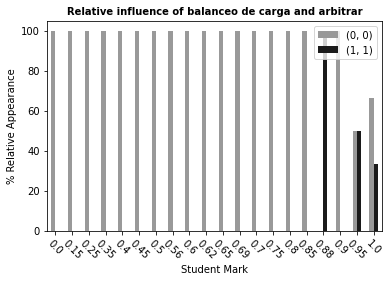

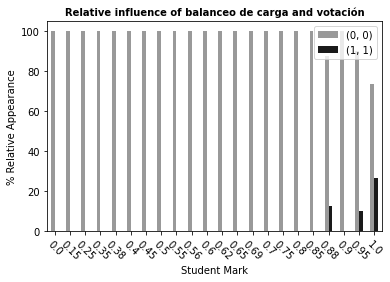

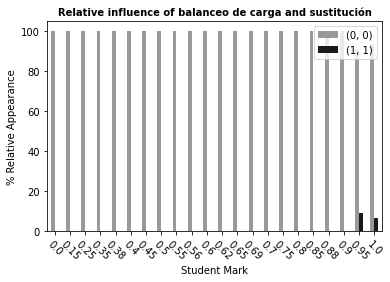

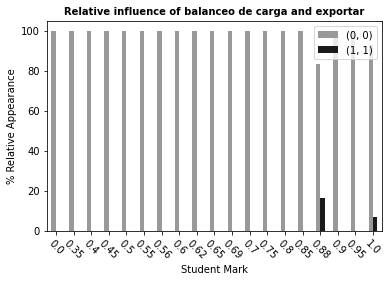

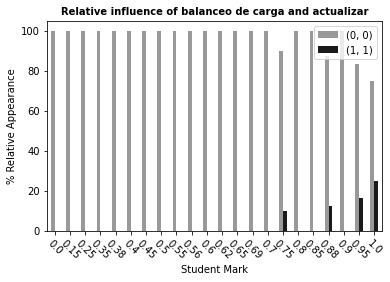

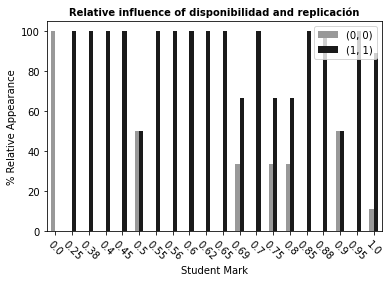

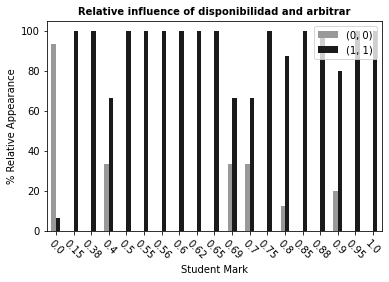

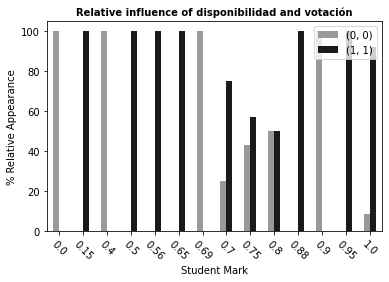

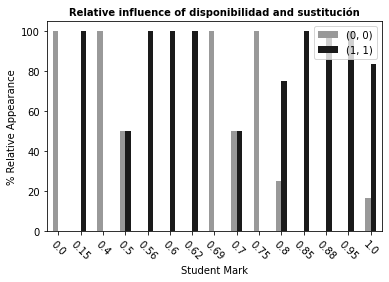

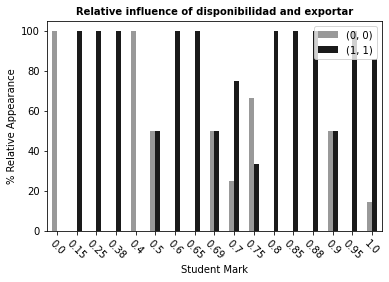

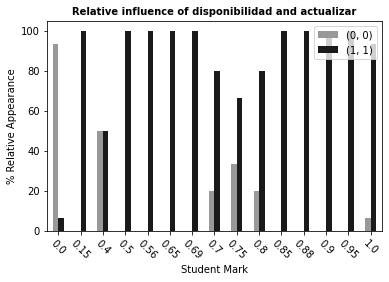

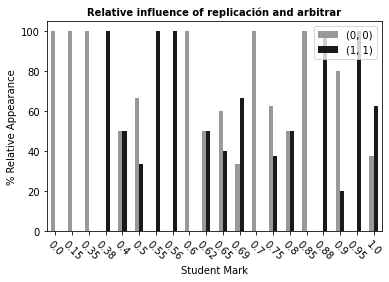

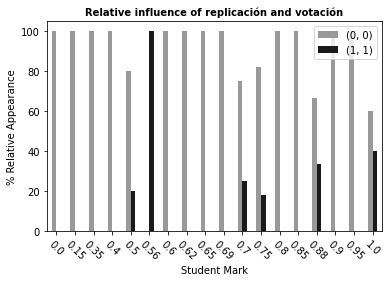

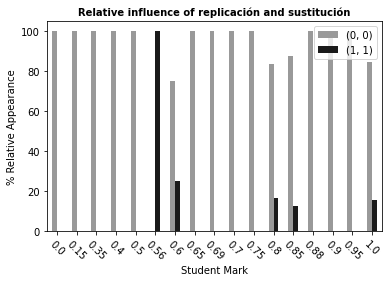

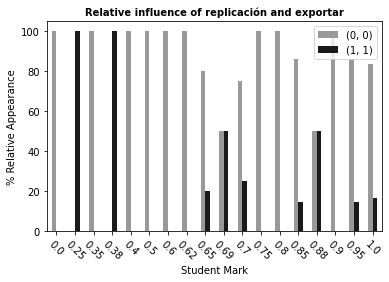

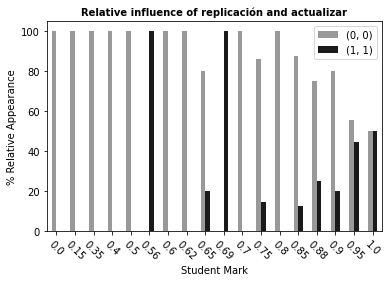

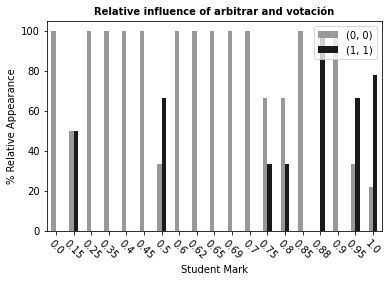

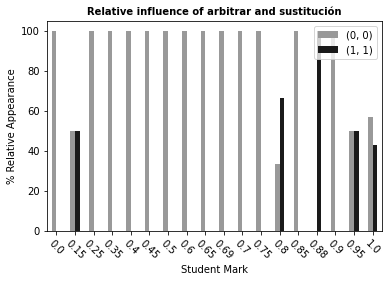

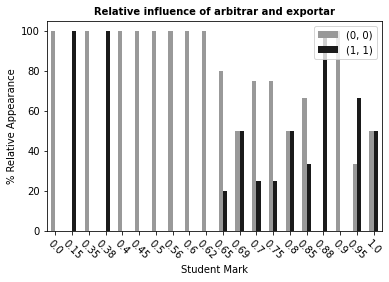

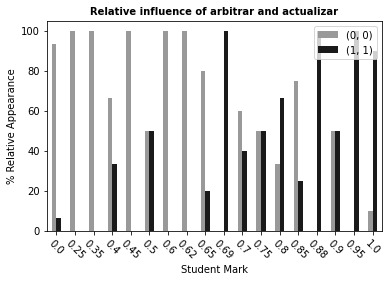

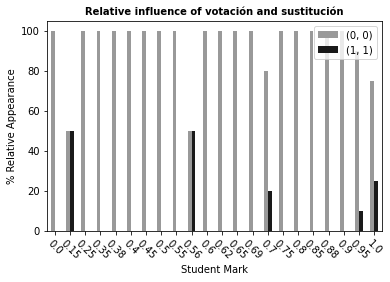

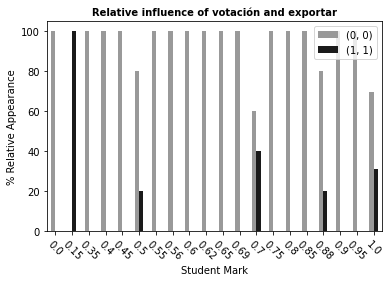

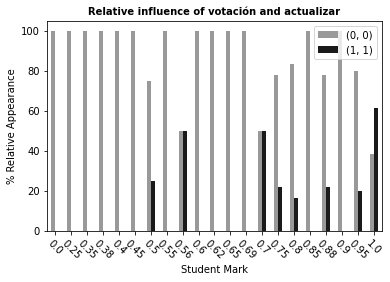

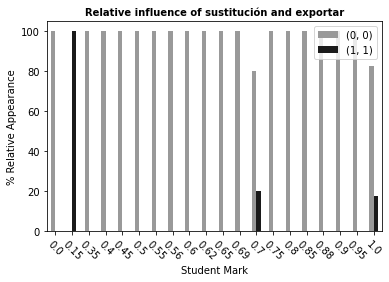

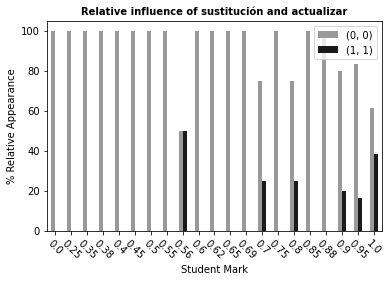

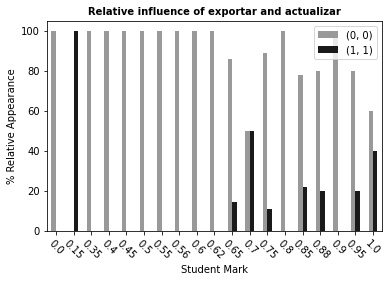

In [63]:
lemmatizedKeywords_cpy = lemmatizedKeywords.copy()
i=0
for k in lemmatizedKeywords:
    for j in lemmatizedKeywords_cpy:
        if j == k:
            continue
        else:
            new_df = df[df[k] == df[j]]
            plot = pd.crosstab(index=new_df['nota'],
            columns=[new_df[k],new_df[j]]).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar', color = [(0.6,0.6,0.6),(0.1,0.1,0.1)])
            plot.set_title("Relative influence of "+ k + " and " + j, fontsize = 10, fontweight = "bold")

            plt.xlabel("Student Mark")
            plt.ylabel("% Relative Appearance")
            plt.legend(loc=1)
            plt.xticks(rotation=-45)
            plt.gcf().subplots_adjust(bottom=0.15)
            plt.savefig("Img__Appearance"+ k + " and " + j + ".png")
            i+=1
    lemmatizedKeywords_cpy.remove(k)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

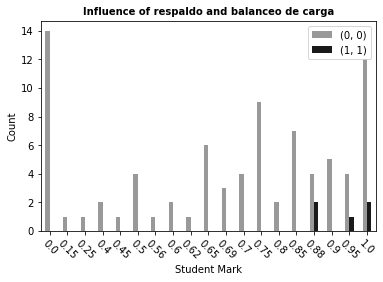

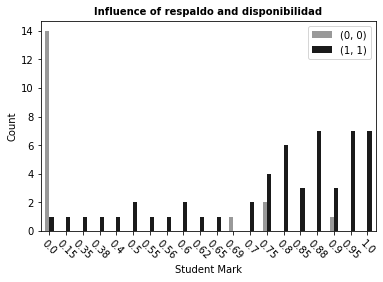

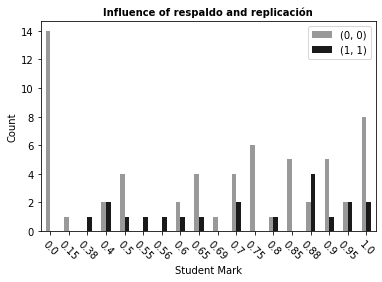

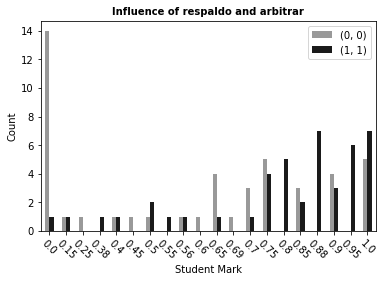

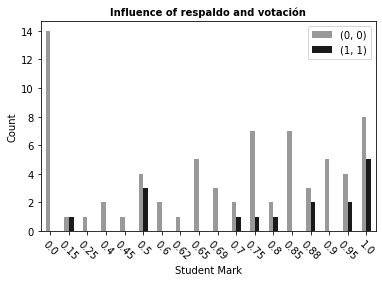

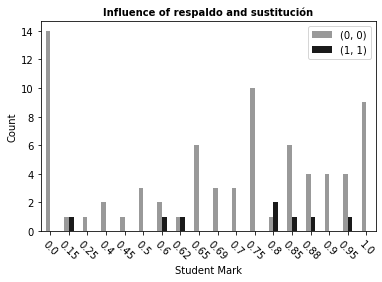

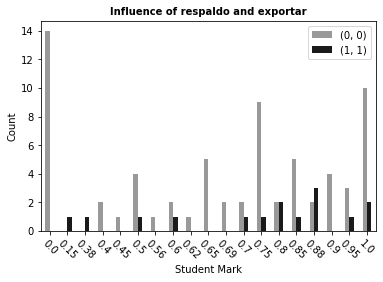

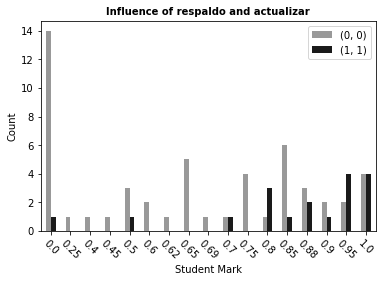

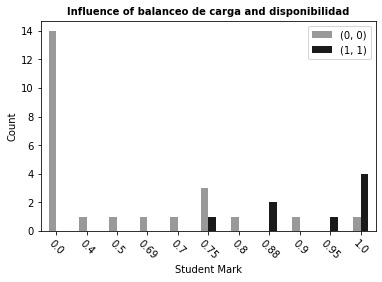

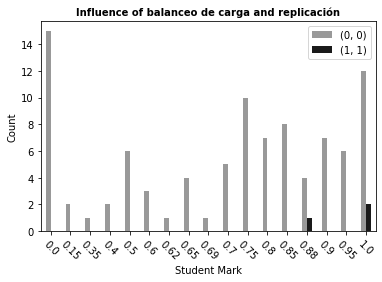

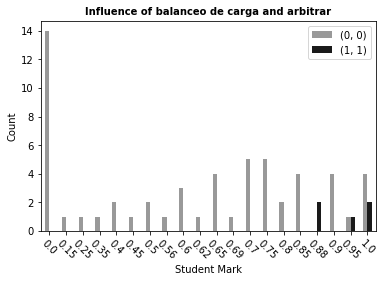

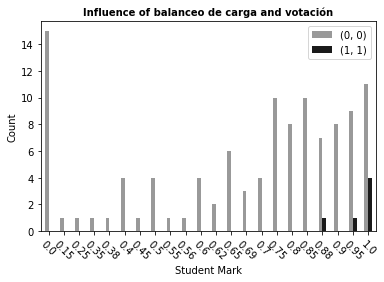

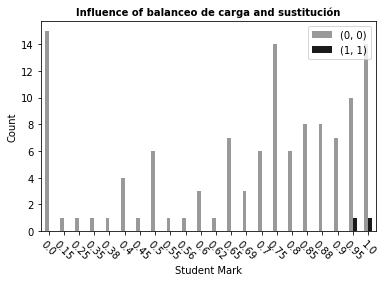

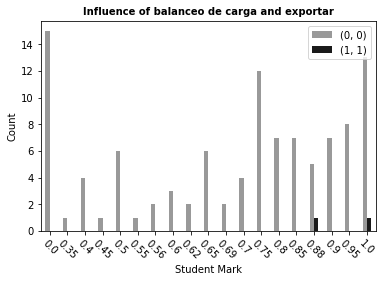

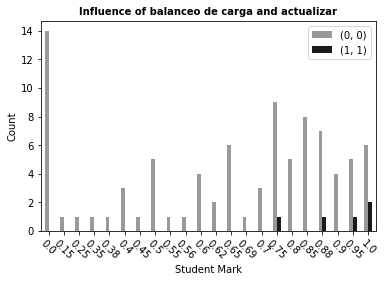

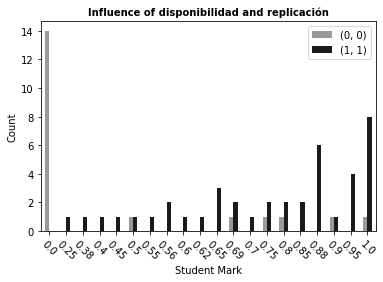

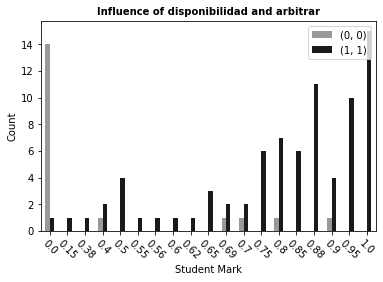

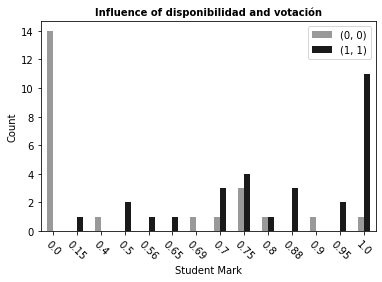

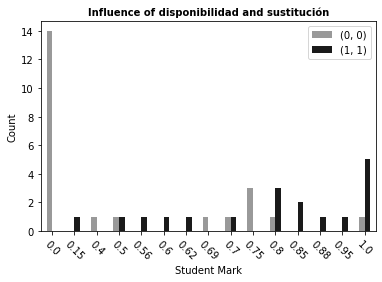

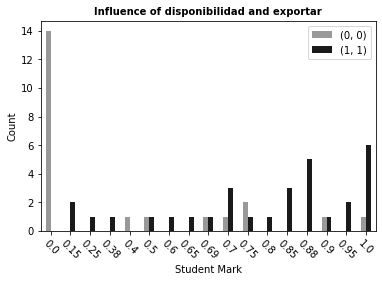

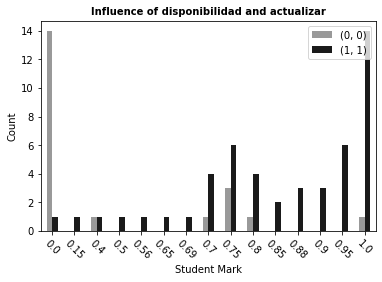

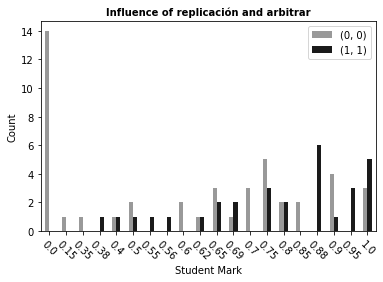

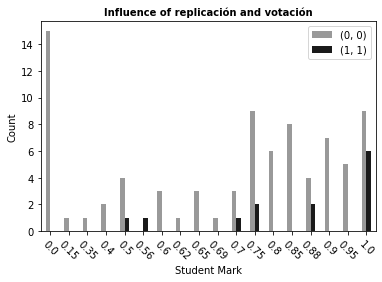

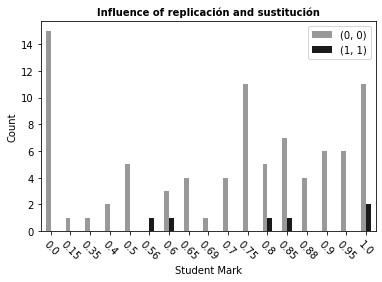

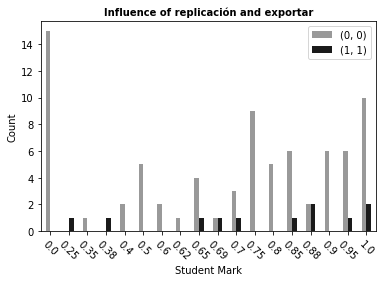

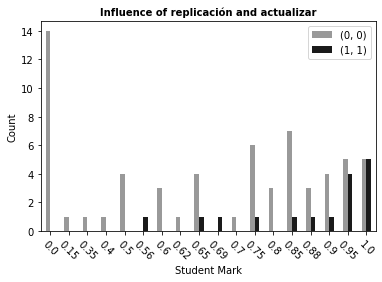

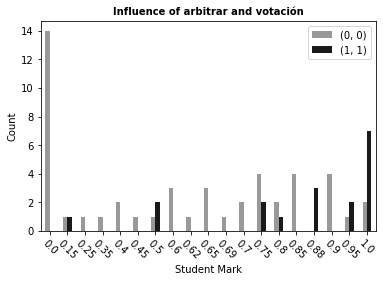

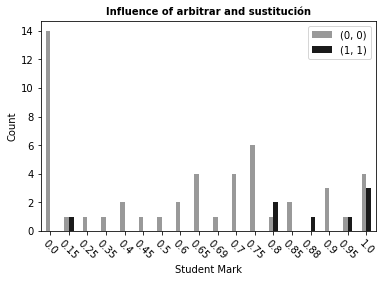

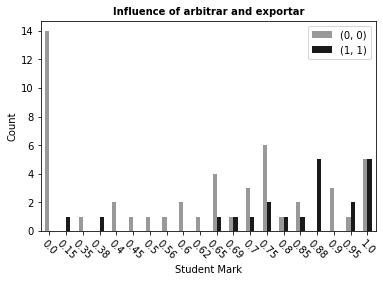

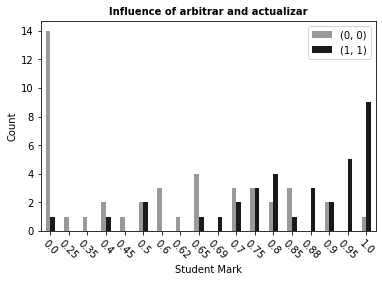

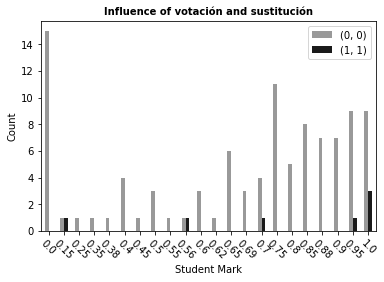

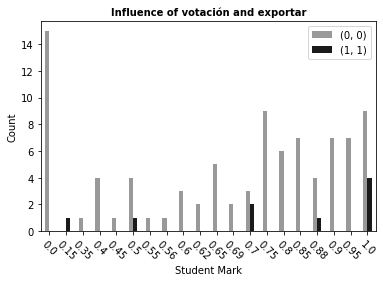

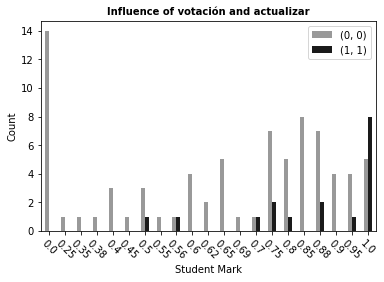

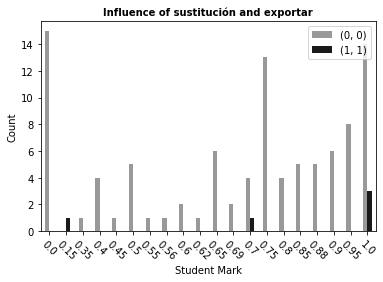

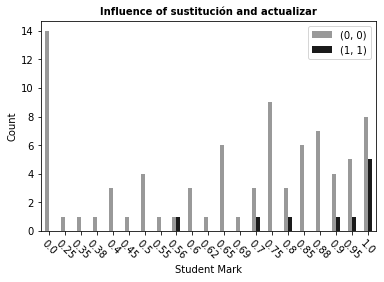

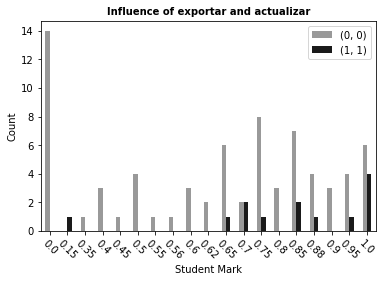

In [64]:
lemmatizedKeywords_cpy = lemmatizedKeywords.copy()
i=0
for k in lemmatizedKeywords:
    for j in lemmatizedKeywords_cpy:
        if j == k:
            continue
        else:
            new_df = df[df[k] == df[j]]
            plot = pd.crosstab(index=new_df['nota'],
            columns=[new_df[k],new_df[j]]).plot(kind='bar', color = [(0.6,0.6,0.6),(0.1,0.1,0.1)])

            plot.set_title("Influence of "+ k + " and " + j, fontsize = 10, fontweight = "bold")
            plt.xticks(rotation=-45)
            plt.xlabel("Student Mark")
            plt.ylabel("Count")
            plt.legend(loc=1)
            plt.gcf().subplots_adjust(bottom=0.15)
            plt.savefig("Img_Appearance"+ k + " and " + j + ".png")
            i+=1
    lemmatizedKeywords_cpy.remove(k)



**MATRIZ DE CORRELACIÓN**

Para ello es necesario transformar las variables categóricas en numéricas

In [65]:
df2 = df.astype(float)

In [66]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1056c39c8300ac26304ad7463f5ea8ce to 39e7c6fcf3761c9b8d35b98c8c382305
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   respaldo           144 non-null    float64
 1   balanceo de carga  144 non-null    float64
 2   disponibilidad     144 non-null    float64
 3   replicación        144 non-null    float64
 4   arbitrar           144 non-null    float64
 5   votación           144 non-null    float64
 6   sustitución        144 non-null    float64
 7   exportar           144 non-null    float64
 8   actualizar         144 non-null    float64
 9   nota               144 non-null    float64
dtypes: float64(10)
memory usage: 17.4+ KB


In [67]:
df2.describe()

,respaldo,balanceo de carga,disponibilidad,replicación,arbitrar,votación,sustitución,exportar,actualizar,nota
count,144.000000,144.000000,144.000000,144.00000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,0.402778,0.055556,0.833333,0.31250,0.583333,0.208333,0.131944,0.222222,0.361111,0.694028
std,0.492169,0.229861,0.373979,0.46513,0.494727,0.407534,0.339612,0.417191,0.481999,0.300448
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000
50%,0.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.750000
75%,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.900000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


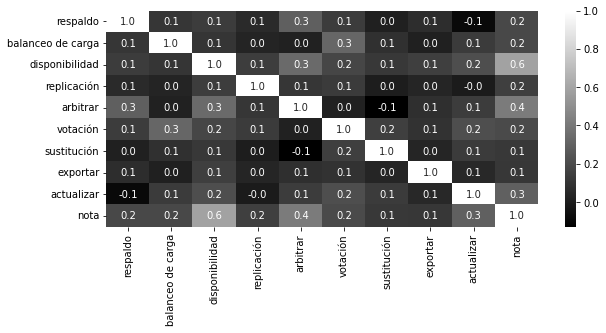

In [68]:
plt.figure(figsize=(10,5))
sns.heatmap(df2.corr(),annot=True,fmt='.1f', cmap= "gray")
plt.gcf().subplots_adjust(bottom=0.28,left =0.15 )
plt.savefig("Img_MatrizCorrelacion.png")

**COEFICIENTE DE CORRELACIÓN DE PEARSON**

In [69]:
from scipy.stats.stats import pearsonr  
lemmatizedKeywords_cpy = lemmatizedKeywords.copy()
i=0
list_pearson = [] 
for k in lemmatizedKeywords:
    for j in lemmatizedKeywords_cpy:
        if j == k:
            continue
        else:
            a = df[j]
            b = df[k]
            list_pearson.append([j,k,pearsonr(a,b)[0]])  

    lemmatizedKeywords_cpy.remove(k)


In [70]:
df = pd.DataFrame(list_pearson)
df.to_csv('CSV_CPearson.csv')
list_pearson

[['balanceo de carga', 'respaldo', 0.10989104295939639],
 ['disponibilidad', 'respaldo', 0.1393074864530851],
 ['replicación', 'respaldo', 0.05727652847757037],
 ['arbitrar', 'respaldo', 0.2919863748102095],
 ['votación', 'respaldo', 0.13655349765454547],
 ['sustitución', 'respaldo', 0.014526967835589932],
 ['exportar', 'respaldo', 0.0718995811991051],
 ['actualizar', 'respaldo', -0.08679746646064457],
 ['disponibilidad', 'balanceo de carga', 0.10846522890932807],
 ['replicación', 'balanceo de carga', 0.032703497008386456],
 ['arbitrar', 'balanceo de carga', 0.02049800154226967],
 ['votación', 'balanceo de carga', 0.32348719116573565],
 ['sustitución', 'balanceo de carga', 0.0846043423048847],
 ['exportar', 'balanceo de carga', 0.01620509308880412],
 ['actualizar', 'balanceo de carga', 0.13324887481766265],
 ['replicación', 'disponibilidad', 0.14070529413628968],
 ['arbitrar', 'disponibilidad', 0.3401680257083045],
 ['votación', 'disponibilidad', 0.18353258709644937],
 ['sustitución', 

**RELACION NÚMERO DE KEYWORDS NOTA**

Notas con valor mayor a 0.5

In [71]:
plot_list=[]
#for r_mark in a:

for j in real_marks_category:
    if round(float(j),3) >= 0.5:
        for i in range(len(len_list)):  
            if round(float(len_list[i][1]),3) == round(float(j),3):
                plot_list.append([len_list[i][0],len_list[i][1]])


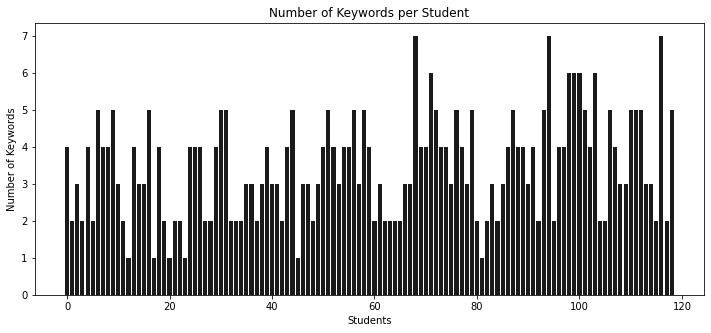

In [72]:
plot_list = np.array(plot_list)

 
## Declaramos valores para el eje x
eje_x = np.linspace(0.0, float(len(plot_list)), num= len(plot_list), endpoint=False)
 
## Declaramos valores para el eje y
eje_y = plot_list[:,0]
 
## Creamos Gráfica
plt.figure(figsize=(12,5))
plt.bar(eje_x, eje_y, color = [(0.1,0.1,0.1)])
 
## Legenda en el eje y
plt.ylabel('Number of Keywords')
 
## Legenda en el eje x
plt.xlabel('Students')
 
## Título de Gráfica
plt.title('Number of Keywords per Student')
plt.savefig("Img_KeywordsperMark_mas05_1.png")
## Mostramos Gráfica
plt.show()


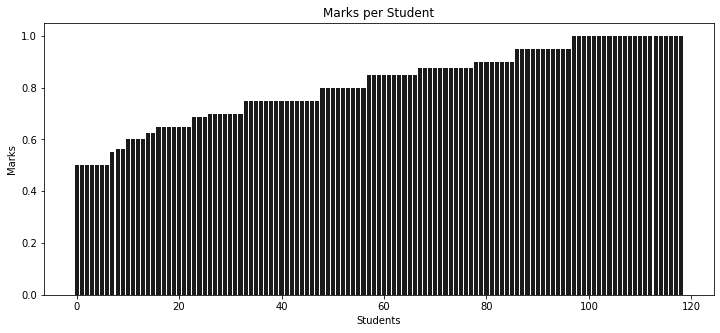

In [73]:
plot_list = np.array(plot_list)
 
## Declaramos valores para el eje x
eje_x = np.linspace(0.0, float(len(plot_list)), num= len(plot_list), endpoint=False)
 
## Declaramos valores para el eje y
eje_y = plot_list[:,1]
 
## Creamos Gráfica
plt.figure(figsize=(12,5))
plt.bar(eje_x, eje_y, color = [(0.1,0.1,0.1)])
 
## Legenda en el eje y
plt.ylabel('Marks')
 
## Legenda en el eje x
plt.xlabel('Students')
 
## Título de Gráfica
plt.title('Marks per Student')
plt.savefig("Img_KeywordsperMark_mas05_2.png")
 
## Mostramos Gráfica
plt.show()


Notas con valor inferior a 0.5

In [74]:
plot_list=[]
#for r_mark in a:

for j in real_marks_category:
    if round(float(j),3) < 0.5:
        for i in range(len(len_list)):  
            if round(float(len_list[i][1]),3) == round(float(j),3):
                plot_list.append([len_list[i][0],len_list[i][1]])


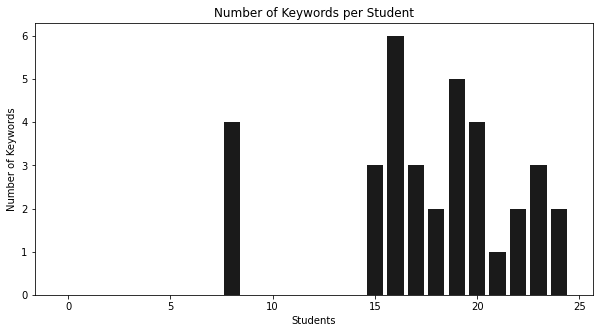

In [75]:
plot_list = np.array(plot_list)
 
## Declaramos valores para el eje x
eje_x = np.linspace(0.0, float(len(plot_list)), num= len(plot_list), endpoint=False)
 
## Declaramos valores para el eje y
eje_y = plot_list[:,0]
 
## Creamos Gráfica
plt.figure(figsize=(10,5))
plt.bar(eje_x, eje_y, color = [(0.1,0.1,0.1)])
 
## Legenda en el eje y
plt.ylabel('Number of Keywords')
 
## Legenda en el eje x
plt.xlabel('Students')
 
## Título de Gráfica
plt.title('Number of Keywords per Student')
plt.savefig("Img_KeywordsperMark_menos05_1.png")
## Mostramos Gráfica
plt.show()


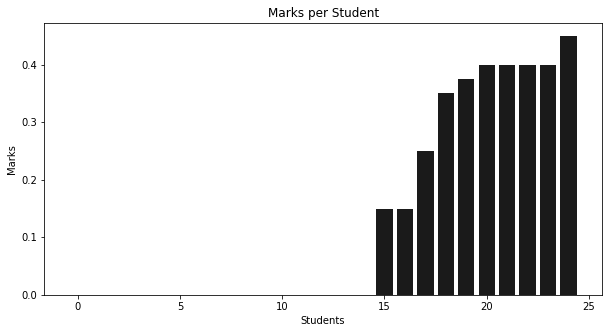

In [76]:
plot_list = np.array(plot_list)
 
## Declaramos valores para el eje x
eje_x = np.linspace(0.0, float(len(plot_list)), num= len(plot_list), endpoint=False)
 
## Declaramos valores para el eje y
eje_y = plot_list[:,1]
 
## Creamos Gráfica
plt.figure(figsize=(10,5))
plt.bar(eje_x, eje_y, color = [(0.1,0.1,0.1)])
 
## Legenda en el eje y
plt.ylabel('Marks')
 
## Legenda en el eje x
plt.xlabel('Students')
 
## Título de Gráfica
plt.title('Marks per Student')
plt.savefig("Img_KeywordsperMark_menos05_2.png")
## Mostramos Gráfica
plt.show()


Todas las notas

In [77]:
plot_list=[]
#for r_mark in a:

for j in real_marks_category:
    if round(float(j),3) >= 0:
        for i in range(len(len_list)):  
            if round(float(len_list[i][1]),3) == round(float(j),3):
                plot_list.append([len_list[i][0],len_list[i][1]])


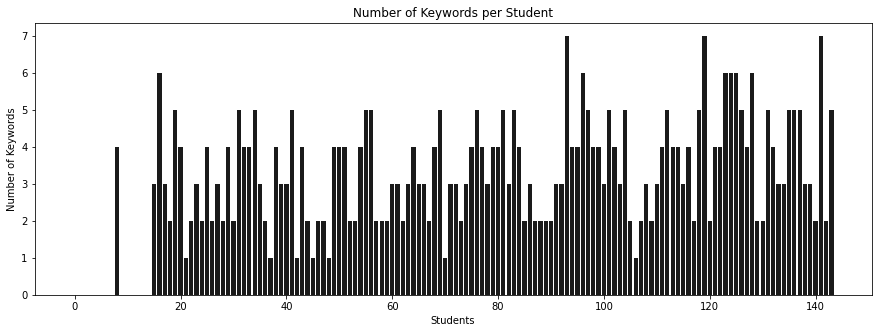

In [78]:
plot_list = np.array(plot_list)

 
## Declaramos valores para el eje x
eje_x = np.linspace(0.0, float(len(plot_list)), num= len(plot_list), endpoint=False)
 
## Declaramos valores para el eje y
eje_y = plot_list[:,0]
 
## Creamos Gráfica
plt.figure(figsize=(15,5))
plt.bar(eje_x, eje_y, color = [(0.1,0.1,0.1)])
 
## Legenda en el eje y
plt.ylabel('Number of Keywords')
 
## Legenda en el eje x
plt.xlabel('Students')
 
## Título de Gráfica
plt.title('Number of Keywords per Student')
plt.savefig("Img_All_KeywordsperMark.png")
## Mostramos Gráfica
plt.show()


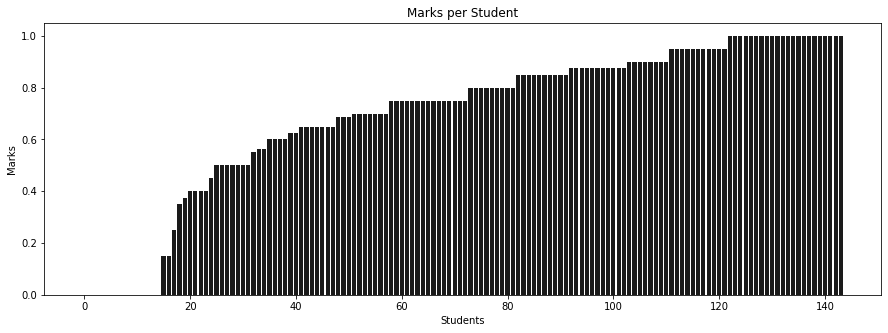

In [79]:
plot_list = np.array(plot_list)
 
## Declaramos valores para el eje x
eje_x = np.linspace(0.0, float(len(plot_list)), num= len(plot_list), endpoint=False)
 
## Declaramos valores para el eje y
eje_y = plot_list[:,1]
 
## Creamos Gráfica
plt.figure(figsize=(15,5))
plt.bar(eje_x, eje_y, color = [(0.1,0.1,0.1)])
 
## Legenda en el eje y
plt.ylabel('Marks')
 
## Legenda en el eje x
plt.xlabel('Students')
 
## Título de Gráfica
plt.title('Marks per Student')
plt.savefig("Img_ALL_KeywordsperMark_mas05_2.png")
 
## Mostramos Gráfica
plt.show()
